# <font color='red'>Backtest vectorizado para una estrategia 'Regresion lineal' definida.</font>

### Hackeado by J3viton (learning BackTesting 2021).

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis
import regresionAMedia as rg  #cambiar segun el módulo con la estrategia implementado
import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

{'id': 1473252352, 'first_name': 'vital_bot', 'is_bot': True, 'username': 'vital_quant_bot', 'can_join_groups': True, 'can_read_all_group_messages': False, 'supports_inline_queries': False}


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'HII'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2011,1,2)
Fecha_Final_Backtesting    = dt.datetime(2022,9,15)
Fecha_Final_Backtesting    = dt.datetime.today()




***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 200 sesiones
startWindow2 = start2  #dt.datetime(2008,1,5)
endWindow2   =startWindow2 + dt.timedelta(days=500) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   4336 sesiones
Tamaño de la ventana a analizar paso a paso:   500 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-03-22,35.720001,37.599998,34.000000,37.490002,32.218040,491400
2011-03-23,37.070000,37.799999,36.950001,37.250000,32.011795,601200
2011-03-24,37.500000,37.500000,37.150002,37.250000,32.011795,230400
2011-03-25,37.500000,39.250000,37.250000,39.250000,33.730537,497400
2011-03-28,39.000000,39.000000,37.750000,37.750000,32.441483,53100


***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(back=True)    #Creamos la clase

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2011-03-22', '2011-03-23', '2011-03-24', '2011-03-25',
               '2011-03-28', '2011-03-29', '2011-03-30', '2011-03-31',
               '2011-04-01', '2011-04-04',
               ...
               '2022-11-02', '2022-11-03', '2022-11-04', '2022-11-07',
               '2022-11-08', '2022-11-09', '2022-11-10', '2022-11-11',
               '2022-11-14', '2022-11-15'],
              dtype='datetime64[ns]', name='Date', length=2935, freq=None)

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [11]:
startWindow

'2011-01-02'

In [12]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [13]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


In [14]:
#Para pruebas
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) 
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
            
    else:
        print('..............Día sin sesión, next please')

        

end date: 2012-05-16
 Datos desde archivo
Coefficients: 
 [0.00141615]
Independent term: 
 33.94138149606757
Coefficients: 
 [0.07062152]
Independent term: 
 25.772008979854302
Coefficients: 
 [0.0398107]
Independent term: 
 31.685010412357
................................................Analizando, muestra 0 de 4336 fecha 2012-05-16
end date: 2012-05-17
 Datos desde archivo
Coefficients: 
 [0.00152377]
Independent term: 
 33.9309423333333
Coefficients: 
 [0.07103179]
Independent term: 
 25.748437311257888
Coefficients: 
 [0.03973945]
Independent term: 
 31.687219255083207
................................................Analizando, muestra 1 de 4336 fecha 2012-05-17
end date: 2012-05-18
 Datos desde archivo
Coefficients: 
 [0.00162495]
Independent term: 
 33.92109390618575
Coefficients: 
 [0.07137365]
Independent term: 
 25.733171638659574
Coefficients: 
 [0.03965029]
Independent term: 
 31.690012809479605
................................................Analizando, muestra 2 de 4336 fe

................................................Analizando, muestra 33 de 4336 fecha 2012-06-18
end date: 2012-06-19
 Datos desde archivo
Coefficients: 
 [0.00454244]
Independent term: 
 33.625408015750324
Coefficients: 
 [0.07128408]
Independent term: 
 26.511034412099356
Coefficients: 
 [0.03611193]
Independent term: 
 31.81482245813316
................................................Analizando, muestra 34 de 4336 fecha 2012-06-19
end date: 2012-06-20
 Datos desde archivo
Coefficients: 
 [0.00483856]
Independent term: 
 33.5944147466428
Coefficients: 
 [0.07133665]
Independent term: 
 26.56770305662013
Coefficients: 
 [0.03595144]
Independent term: 
 31.821027983932343
................................................Analizando, muestra 35 de 4336 fecha 2012-06-20
end date: 2012-06-21
 Datos desde archivo
Coefficients: 
 [0.00508655]
Independent term: 
 33.568375032605545
Coefficients: 
 [0.07126017]
Independent term: 
 26.6338134967747
Coefficients: 
 [0.03579896]
Independent term: 


................................................Analizando, muestra 65 de 4336 fecha 2012-07-20
end date: 2012-07-21
..............Día sin sesión, next please
end date: 2012-07-22
..............Día sin sesión, next please
end date: 2012-07-23
 Datos desde archivo
Coefficients: 
 [0.00985372]
Independent term: 
 33.05166042785517
Coefficients: 
 [0.06375053]
Independent term: 
 28.77892254929044
Coefficients: 
 [0.03408826]
Independent term: 
 31.898521850267507
................................................Analizando, muestra 68 de 4336 fecha 2012-07-23
end date: 2012-07-24
 Datos desde archivo
Coefficients: 
 [0.00996292]
Independent term: 
 33.03939333311204
Coefficients: 
 [0.06252677]
Independent term: 
 28.974686731651648
Coefficients: 
 [0.03403832]
Independent term: 
 31.900836110641787
................................................Analizando, muestra 69 de 4336 fecha 2012-07-24
end date: 2012-07-25
 Datos desde archivo
Coefficients: 
 [0.01010178]
Independent term: 
 33.023

................................................Analizando, muestra 98 de 4336 fecha 2012-08-22
end date: 2012-08-23
 Datos desde archivo
Coefficients: 
 [0.01295048]
Independent term: 
 32.691877092704814
Coefficients: 
 [0.04728622]
Independent term: 
 31.822821145413528
Coefficients: 
 [0.03295025]
Independent term: 
 31.95515767684867
................................................Analizando, muestra 99 de 4336 fecha 2012-08-23
end date: 2012-08-24
 Datos desde archivo
Coefficients: 
 [0.01307345]
Independent term: 
 32.677121602782954
Coefficients: 
 [0.0468444]
Independent term: 
 31.916582321622474
Coefficients: 
 [0.03291352]
Independent term: 
 31.95714091899928
................................................Analizando, muestra 100 de 4336 fecha 2012-08-24
end date: 2012-08-25
..............Día sin sesión, next please
end date: 2012-08-26
..............Día sin sesión, next please
end date: 2012-08-27
 Datos desde archivo
Coefficients: 
 [0.01319243]
Independent term: 
 32.66

 [0.03233223]
Independent term: 
 31.99034257687929
................................................Analizando, muestra 132 de 4336 fecha 2012-09-25
end date: 2012-09-26
 Datos desde archivo
Coefficients: 
 [0.01588101]
Independent term: 
 32.32909986815412
Coefficients: 
 [0.037853]
Independent term: 
 33.93107637376927
Coefficients: 
 [0.0323194]
Independent term: 
 31.991128987074624
................................................Analizando, muestra 133 de 4336 fecha 2012-09-26
end date: 2012-09-27
 Datos desde archivo
Coefficients: 
 [0.01603615]
Independent term: 
 32.309293481272206
Coefficients: 
 [0.03739314]
Independent term: 
 34.03758232543718
Coefficients: 
 [0.0323089]
Independent term: 
 31.991776820073838
................................................Analizando, muestra 134 de 4336 fecha 2012-09-27
end date: 2012-09-28
 Datos desde archivo
Coefficients: 
 [0.01617941]
Independent term: 
 32.29095597149747
Coefficients: 
 [0.03692443]
Independent term: 
 34.14246891050

................................................Analizando, muestra 163 de 4336 fecha 2012-10-26
end date: 2012-10-27
..............Día sin sesión, next please
end date: 2012-10-28
..............Día sin sesión, next please
end date: 2012-10-29
..............Día sin sesión, next please
end date: 2012-10-30
..............Día sin sesión, next please
end date: 2012-10-31
 Datos desde archivo
Coefficients: 
 [0.01845864]
Independent term: 
 31.99154507602152
Coefficients: 
 [0.02866941]
Independent term: 
 35.97834351724653
Coefficients: 
 [0.03209198]
Independent term: 
 32.309496985304754
................................................Analizando, muestra 168 de 4336 fecha 2012-10-31
end date: 2012-11-01
 Datos desde archivo
Coefficients: 
 [0.01860195]
Independent term: 
 31.972150198124798
Coefficients: 
 [0.02866666]
Independent term: 
 36.02506736755371
Coefficients: 
 [0.0320579]
Independent term: 
 32.34646783487938
................................................Analizando, muestra

................................................Analizando, muestra 198 de 4336 fecha 2012-11-30
end date: 2012-12-01
..............Día sin sesión, next please
end date: 2012-12-02
..............Día sin sesión, next please
end date: 2012-12-03
 Datos desde archivo
Coefficients: 
 [0.01955985]
Independent term: 
 31.84043871756071
Coefficients: 
 [0.02692266]
Independent term: 
 36.6907449574257
Coefficients: 
 [0.03122944]
Independent term: 
 33.12222674732373
................................................Analizando, muestra 201 de 4336 fecha 2012-12-03
end date: 2012-12-04
 Datos desde archivo
Coefficients: 
 [0.0195611]
Independent term: 
 31.84026142514119
Coefficients: 
 [0.02661391]
Independent term: 
 36.740665843451204
Coefficients: 
 [0.03118352]
Independent term: 
 33.15823111643943
................................................Analizando, muestra 202 de 4336 fecha 2012-12-04
end date: 2012-12-05
 Datos desde archivo
Coefficients: 
 [0.01956072]
Independent term: 
 31.8403

................................................Analizando, muestra 232 de 4336 fecha 2013-01-03
end date: 2013-01-04
 Datos desde archivo
Coefficients: 
 [0.02060131]
Independent term: 
 31.68696793437067
Coefficients: 
 [0.02500817]
Independent term: 
 37.48243746971016
Coefficients: 
 [0.02992813]
Independent term: 
 33.93252427307342
................................................Analizando, muestra 233 de 4336 fecha 2013-01-04
end date: 2013-01-05
..............Día sin sesión, next please
end date: 2013-01-06
..............Día sin sesión, next please
end date: 2013-01-07
 Datos desde archivo
Coefficients: 
 [0.02068048]
Independent term: 
 31.675092047071118
Coefficients: 
 [0.0251878]
Independent term: 
 37.49551355447342
Coefficients: 
 [0.02988096]
Independent term: 
 33.9679769027391
................................................Analizando, muestra 236 de 4336 fecha 2013-01-07
end date: 2013-01-08
 Datos desde archivo
Coefficients: 
 [0.02074692]
Independent term: 
 31.6651

................................................Analizando, muestra 266 de 4336 fecha 2013-02-06
end date: 2013-02-07
 Datos desde archivo
Coefficients: 
 [0.02239886]
Independent term: 
 31.410664622581933
Coefficients: 
 [0.03399323]
Independent term: 
 37.2082239919634
Coefficients: 
 [0.02985054]
Independent term: 
 34.63667294554014
................................................Analizando, muestra 267 de 4336 fecha 2013-02-07
end date: 2013-02-08
 Datos desde archivo
Coefficients: 
 [0.02248809]
Independent term: 
 31.396596905852988
Coefficients: 
 [0.03444867]
Independent term: 
 37.195556820542066
Coefficients: 
 [0.02989629]
Independent term: 
 34.66213447663469
................................................Analizando, muestra 268 de 4336 fecha 2013-02-08
end date: 2013-02-09
..............Día sin sesión, next please
end date: 2013-02-10
..............Día sin sesión, next please
end date: 2013-02-11
 Datos desde archivo
Coefficients: 
 [0.02257137]
Independent term: 
 31.3

................................................Analizando, muestra 299 de 4336 fecha 2013-03-11
end date: 2013-03-12
 Datos desde archivo
Coefficients: 
 [0.02479756]
Independent term: 
 31.022462842666705
Coefficients: 
 [0.04324412]
Independent term: 
 37.278859712401434
Coefficients: 
 [0.03163916]
Independent term: 
 35.13451238712496
................................................Analizando, muestra 300 de 4336 fecha 2013-03-12
end date: 2013-03-13
 Datos desde archivo
Coefficients: 
 [0.02502853]
Independent term: 
 30.984351982767173
Coefficients: 
 [0.04409506]
Independent term: 
 37.2780910753848
Coefficients: 
 [0.0317631]
Independent term: 
 35.15584152830167
................................................Analizando, muestra 301 de 4336 fecha 2013-03-13
end date: 2013-03-14
 Datos desde archivo
Coefficients: 
 [0.02528583]
Independent term: 
 30.941812219173123
Coefficients: 
 [0.04513005]
Independent term: 
 37.264310425146306
Coefficients: 
 [0.0318961]
Independent term

................................................Analizando, muestra 331 de 4336 fecha 2013-04-12
end date: 2013-04-13
..............Día sin sesión, next please
end date: 2013-04-14
..............Día sin sesión, next please
end date: 2013-04-15
 Datos desde archivo
Coefficients: 
 [0.0291986]
Independent term: 
 30.28168629209112
Coefficients: 
 [0.06028671]
Independent term: 
 37.33632227769539
Coefficients: 
 [0.03600741]
Independent term: 
 35.58276184323943
................................................Analizando, muestra 334 de 4336 fecha 2013-04-15
end date: 2013-04-16
 Datos desde archivo
Coefficients: 
 [0.0293329]
Independent term: 
 30.25849659159531
Coefficients: 
 [0.06083983]
Independent term: 
 37.34418649246443
Coefficients: 
 [0.0362545]
Independent term: 
 35.600288456664565
................................................Analizando, muestra 335 de 4336 fecha 2013-04-16
end date: 2013-04-17
 Datos desde archivo
Coefficients: 
 [0.02944582]
Independent term: 
 30.23896

Coefficients: 
 [0.0321132]
Independent term: 
 29.76760554667358
Coefficients: 
 [0.07434091]
Independent term: 
 37.33342962805905
Coefficients: 
 [0.04229261]
Independent term: 
 35.919391435663464
................................................Analizando, muestra 364 de 4336 fecha 2013-05-15
end date: 2013-05-16
 Datos desde archivo
Coefficients: 
 [0.03227689]
Independent term: 
 29.738141375602325
Coefficients: 
 [0.07502615]
Independent term: 
 37.34639832966363
Coefficients: 
 [0.04261832]
Independent term: 
 35.9335905092356
................................................Analizando, muestra 365 de 4336 fecha 2013-05-16
end date: 2013-05-17
 Datos desde archivo
Coefficients: 
 [0.03245133]
Independent term: 
 29.70668493430646
Coefficients: 
 [0.0757931]
Independent term: 
 37.3541863916881
Coefficients: 
 [0.04294842]
Independent term: 
 35.94772579164807
................................................Analizando, muestra 366 de 4336 fecha 2013-05-17
end date: 2013-05-18
...

................................................Analizando, muestra 397 de 4336 fecha 2013-06-17
end date: 2013-06-18
 Datos desde archivo
Coefficients: 
 [0.03549461]
Independent term: 
 29.14702534569954
Coefficients: 
 [0.08839824]
Independent term: 
 37.7590252548901
Coefficients: 
 [0.05049165]
Independent term: 
 36.25320892509507
................................................Analizando, muestra 398 de 4336 fecha 2013-06-18
end date: 2013-06-19
 Datos desde archivo
Coefficients: 
 [0.03563503]
Independent term: 
 29.120673676608305
Coefficients: 
 [0.08891687]
Independent term: 
 37.79067150856132
Coefficients: 
 [0.050874]
Independent term: 
 36.268507060253945
................................................Analizando, muestra 399 de 4336 fecha 2013-06-19
end date: 2013-06-20
 Datos desde archivo
Coefficients: 
 [0.03575984]
Independent term: 
 29.097210022387163
Coefficients: 
 [0.08925633]
Independent term: 
 37.83809541389124
Coefficients: 
 [0.05125591]
Independent term: 

................................................Analizando, muestra 429 de 4336 fecha 2013-07-19
end date: 2013-07-20
..............Día sin sesión, next please
end date: 2013-07-21
..............Día sin sesión, next please
end date: 2013-07-22
 Datos desde archivo
Coefficients: 
 [0.0388585]
Independent term: 
 28.501972035854727
Coefficients: 
 [0.10350215]
Independent term: 
 38.22863576803634
Coefficients: 
 [0.05957801]
Independent term: 
 36.64082444322678
................................................Analizando, muestra 432 de 4336 fecha 2013-07-22
end date: 2013-07-23
 Datos desde archivo
Coefficients: 
 [0.03906549]
Independent term: 
 28.46153928043345
Coefficients: 
 [0.10482565]
Independent term: 
 38.199647700751
Coefficients: 
 [0.06002823]
Independent term: 
 36.65633512240612
................................................Analizando, muestra 433 de 4336 fecha 2013-07-23
end date: 2013-07-24
 Datos desde archivo
Coefficients: 
 [0.03927109]
Independent term: 
 28.42131

 Datos desde archivo
Coefficients: 
 [0.0428524]
Independent term: 
 27.708256966799
Coefficients: 
 [0.12316103]
Independent term: 
 38.623377530112194
Coefficients: 
 [0.07049462]
Independent term: 
 36.98087902800133
................................................Analizando, muestra 462 de 4336 fecha 2013-08-21
end date: 2013-08-22
 Datos desde archivo
Coefficients: 
 [0.04303599]
Independent term: 
 27.671048326608222
Coefficients: 
 [0.12426479]
Independent term: 
 38.61955369237643
Coefficients: 
 [0.07102964]
Independent term: 
 36.99718424854239
................................................Analizando, muestra 463 de 4336 fecha 2013-08-22
end date: 2013-08-23
 Datos desde archivo
Coefficients: 
 [0.04321935]
Independent term: 
 27.633827443935573
Coefficients: 
 [0.12550086]
Independent term: 
 38.59851492013504
Coefficients: 
 [0.07157164]
Independent term: 
 37.0131178870657
................................................Analizando, muestra 464 de 4336 fecha 2013-08-23
en

 [0.0820463]
Independent term: 
 37.47230968603424
................................................Analizando, muestra 495 de 4336 fecha 2013-09-23
end date: 2013-09-24
 Datos desde archivo
Coefficients: 
 [0.04686043]
Independent term: 
 26.8808363889545
Coefficients: 
 [0.13282814]
Independent term: 
 40.56660009412623
Coefficients: 
 [0.08255159]
Independent term: 
 37.50309864531873
................................................Analizando, muestra 496 de 4336 fecha 2013-09-24
end date: 2013-09-25
 Datos desde archivo
Coefficients: 
 [0.04702314]
Independent term: 
 26.846612460620584
Coefficients: 
 [0.13288674]
Independent term: 
 40.69411954054192
Coefficients: 
 [0.08305244]
Independent term: 
 37.53485009701249
................................................Analizando, muestra 497 de 4336 fecha 2013-09-25
end date: 2013-09-26
 Datos desde archivo
Coefficients: 
 [0.04718406]
Independent term: 
 26.81271109892615
Coefficients: 
 [0.13295202]
Independent term: 
 40.81972394630

Coefficients: 
 [0.09288828]
Independent term: 
 38.38013551411744
................................................Analizando, muestra 526 de 4336 fecha 2013-10-24
end date: 2013-10-25
 Datos desde archivo
Coefficients: 
 [0.05083744]
Independent term: 
 26.029119488603023
Coefficients: 
 [0.13881622]
Independent term: 
 43.10133576635105
Coefficients: 
 [0.09334527]
Independent term: 
 38.42711263105509
................................................Analizando, muestra 527 de 4336 fecha 2013-10-25
end date: 2013-10-26
..............Día sin sesión, next please
end date: 2013-10-27
..............Día sin sesión, next please
end date: 2013-10-28
 Datos desde archivo
Coefficients: 
 [0.05100912]
Independent term: 
 25.99169250731612
Coefficients: 
 [0.13896188]
Independent term: 
 43.22874321496308
Coefficients: 
 [0.09379917]
Independent term: 
 38.47489004980044
................................................Analizando, muestra 530 de 4336 fecha 2013-10-28
end date: 2013-10-29
 Datos d

................................................Analizando, muestra 558 de 4336 fecha 2013-11-25
end date: 2013-11-26
 Datos desde archivo
Coefficients: 
 [0.05542374]
Independent term: 
 25.011798692518425
Coefficients: 
 [0.15107086]
Independent term: 
 45.36804921164441
Coefficients: 
 [0.10328249]
Independent term: 
 39.60763082537986
................................................Analizando, muestra 559 de 4336 fecha 2013-11-26
end date: 2013-11-27
 Datos desde archivo
Coefficients: 
 [0.05568709]
Independent term: 
 24.952456357579237
Coefficients: 
 [0.15216662]
Independent term: 
 45.44497163914922
Coefficients: 
 [0.1037689]
Independent term: 
 39.6657138185517
................................................Analizando, muestra 560 de 4336 fecha 2013-11-27
end date: 2013-11-28
..............Día sin sesión, next please
end date: 2013-11-29
 Datos desde archivo
Coefficients: 
 [0.05594077]
Independent term: 
 24.895208718001523
Coefficients: 
 [0.1530777]
Independent term: 
 45

Coefficients: 
 [0.06085932]
Independent term: 
 23.767508459638872
Coefficients: 
 [0.17454465]
Independent term: 
 46.97250740108205
Coefficients: 
 [0.1147009]
Independent term: 
 40.97265868501806
................................................Analizando, muestra 593 de 4336 fecha 2013-12-30
end date: 2013-12-31
 Datos desde archivo
Coefficients: 
 [0.06114913]
Independent term: 
 23.700078757841727
Coefficients: 
 [0.17676302]
Independent term: 
 46.933629783516494
Coefficients: 
 [0.11531843]
Independent term: 
 41.03197183027676
................................................Analizando, muestra 594 de 4336 fecha 2013-12-31
end date: 2014-01-01
..............Día sin sesión, next please
end date: 2014-01-02
 Datos desde archivo
Coefficients: 
 [0.06141012]
Independent term: 
 23.639268325500925
Coefficients: 
 [0.17844154]
Independent term: 
 46.94366706449594
Coefficients: 
 [0.11594652]
Independent term: 
 41.09079466842819
................................................Anali

................................................Analizando, muestra 625 de 4336 fecha 2014-01-31
end date: 2014-02-01
..............Día sin sesión, next please
end date: 2014-02-02
..............Día sin sesión, next please
end date: 2014-02-03
 Datos desde archivo
Coefficients: 
 [0.06752488]
Independent term: 
 22.192406204283618
Coefficients: 
 [0.21579985]
Independent term: 
 47.55301482641875
Coefficients: 
 [0.13197044]
Independent term: 
 42.217616915540425
................................................Analizando, muestra 628 de 4336 fecha 2014-02-03
end date: 2014-02-04
 Datos desde archivo
Coefficients: 
 [0.06775131]
Independent term: 
 22.137986362892747
Coefficients: 
 [0.21620751]
Independent term: 
 47.714602909372815
Coefficients: 
 [0.13280862]
Independent term: 
 42.272313293588525
................................................Analizando, muestra 629 de 4336 fecha 2014-02-04
end date: 2014-02-05
 Datos desde archivo
Coefficients: 
 [0.0679735]
Independent term: 
 22

................................................Analizando, muestra 658 de 4336 fecha 2014-03-05
end date: 2014-03-06
 Datos desde archivo
Coefficients: 
 [0.07340579]
Independent term: 
 20.757060722417968
Coefficients: 
 [0.24019627]
Independent term: 
 49.95557160676415
Coefficients: 
 [0.15056933]
Independent term: 
 43.56561268281616
................................................Analizando, muestra 659 de 4336 fecha 2014-03-06
end date: 2014-03-07
 Datos desde archivo
Coefficients: 
 [0.07372361]
Independent term: 
 20.67834759163168
Coefficients: 
 [0.24212468]
Independent term: 
 50.007744767487935
Coefficients: 
 [0.15148033]
Independent term: 
 43.629713499579076
................................................Analizando, muestra 660 de 4336 fecha 2014-03-07
end date: 2014-03-08
..............Día sin sesión, next please
end date: 2014-03-09
..............Día sin sesión, next please
end date: 2014-03-10
 Datos desde archivo
Coefficients: 
 [0.07404411]
Independent term: 
 20.

 Datos desde archivo
Coefficients: 
 [0.07903303]
Independent term: 
 19.34488029615293
Coefficients: 
 [0.25590386]
Independent term: 
 53.47566559236441
Coefficients: 
 [0.17055297]
Independent term: 
 45.14997235164756
................................................Analizando, muestra 691 de 4336 fecha 2014-04-07
end date: 2014-04-08
 Datos desde archivo
Coefficients: 
 [0.07921989]
Independent term: 
 19.29722928952285
Coefficients: 
 [0.25518203]
Independent term: 
 53.76338796416326
Coefficients: 
 [0.17139505]
Independent term: 
 45.23567797963279
................................................Analizando, muestra 692 de 4336 fecha 2014-04-08
end date: 2014-04-09
 Datos desde archivo
Coefficients: 
 [0.07942522]
Independent term: 
 19.24480152402055
Coefficients: 
 [0.2546984]
Independent term: 
 54.03765962287561
Coefficients: 
 [0.17222394]
Independent term: 
 45.323259886530735
................................................Analizando, muestra 693 de 4336 fecha 2014-04-09
e

................................................Analizando, muestra 722 de 4336 fecha 2014-05-08
end date: 2014-05-09
 Datos desde archivo
Coefficients: 
 [0.08352363]
Independent term: 
 18.18361755203771
Coefficients: 
 [0.24747794]
Independent term: 
 59.23074488113175
Coefficients: 
 [0.18699505]
Independent term: 
 47.52832713799556
................................................Analizando, muestra 723 de 4336 fecha 2014-05-09
end date: 2014-05-10
..............Día sin sesión, next please
end date: 2014-05-11
..............Día sin sesión, next please
end date: 2014-05-12
 Datos desde archivo
Coefficients: 
 [0.08368836]
Independent term: 
 18.140348765133886
Coefficients: 
 [0.24694238]
Independent term: 
 59.47478370609568
Coefficients: 
 [0.18759154]
Independent term: 
 47.64719735260351
................................................Analizando, muestra 726 de 4336 fecha 2014-05-12
end date: 2014-05-13
 Datos desde archivo
Coefficients: 
 [0.08385544]
Independent term: 
 18.09

................................................Analizando, muestra 782 de 4336 fecha 2014-07-07
end date: 2014-07-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 783 de 4336 fecha 2014-07-08
end date: 2014-07-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 784 de 4336 fecha 2014-07-09
end date: 2014-07-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 785 de 4336 fecha 2014-07-10
end date: 2014-07-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 786 de 4336 fecha 2014-07-11
end date: 2014-07-12
..............Día sin sesión, next please
end date: 2014-07-13
..............Día sin sesión, next please
end date: 2014-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 789 de 4336 fecha 201

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 831 de 4336 fecha 2014-08-25
end date: 2014-08-26
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 832 de 4336 fecha 2014-08-26
end date: 2014-08-27
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 833 de 4336 fecha 2014-08-27
end date: 2014-08-28
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 834 de 4336 fecha 2014-08-28
end date: 2014-08-29
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 835 de 4336 fecha 2014-08-29
end date: 2014-08-30
..............Día sin sesión, next please
end date: 2014-08-31
..............Día sin sesión, next please
end date: 2014-09-01
..............Día sin sesión, next please
end date: 2014-09-02
aqui estoy en out
 datos d

................................................Analizando, muestra 867 de 4336 fecha 2014-09-30
end date: 2014-10-01
 Datos desde archivo
Coefficients: 
 [0.0904546]
Independent term: 
 16.266233547496746
Coefficients: 
 [0.04042028]
Independent term: 
 93.82273145874935
Coefficients: 
 [0.14564844]
Independent term: 
 68.3798803342591
................................................Analizando, muestra 868 de 4336 fecha 2014-10-01
end date: 2014-10-02
 Datos desde archivo
Coefficients: 
 [0.09050166]
Independent term: 
 16.252303916019933
Coefficients: 
 [0.03890379]
Independent term: 
 94.07422250662277
Coefficients: 
 [0.1445863]
Independent term: 
 68.63554543050154
................................................Analizando, muestra 869 de 4336 fecha 2014-10-02
end date: 2014-10-03
 Datos desde archivo
Coefficients: 
 [0.0905555]
Independent term: 
 16.236350527934917
Coefficients: 
 [0.03774904]
Independent term: 
 94.28697024672779
Coefficients: 
 [0.14352324]
Independent term: 


 Datos desde archivo
Coefficients: 
 [0.09086738]
Independent term: 
 16.141081506312553
Coefficients: 
 [0.01320044]
Independent term: 
 97.84550574345376
Coefficients: 
 [0.11455031]
Independent term: 
 75.31244864921524
................................................Analizando, muestra 908 de 4336 fecha 2014-11-10
end date: 2014-11-11
 Datos desde archivo
Coefficients: 
 [0.09093006]
Independent term: 
 16.12194260209293
Coefficients: 
 [0.01376597]
Independent term: 
 97.86123565446086
Coefficients: 
 [0.11354748]
Independent term: 
 75.53681468906845
................................................Analizando, muestra 909 de 4336 fecha 2014-11-11
end date: 2014-11-12
 Datos desde archivo
Coefficients: 
 [0.09099226]
Independent term: 
 16.10293132843615
Coefficients: 
 [0.01422385]
Independent term: 
 97.89132661961797
Coefficients: 
 [0.11255919]
Independent term: 
 75.75924764360127
................................................Analizando, muestra 910 de 4336 fecha 2014-11-12


................................................Analizando, muestra 939 de 4336 fecha 2014-12-11
end date: 2014-12-12
 Datos desde archivo
Coefficients: 
 [0.0920036]
Independent term: 
 15.790607898030004
Coefficients: 
 [0.02293215]
Independent term: 
 98.37555053824809
Coefficients: 
 [0.09465222]
Independent term: 
 80.03980955545026
................................................Analizando, muestra 940 de 4336 fecha 2014-12-12
end date: 2014-12-13
..............Día sin sesión, next please
end date: 2014-12-14
..............Día sin sesión, next please
end date: 2014-12-15
 Datos desde archivo
Coefficients: 
 [0.09201345]
Independent term: 
 15.787523147856298
Coefficients: 
 [0.02378313]
Independent term: 
 98.29322806742654
Coefficients: 
 [0.09394706]
Independent term: 
 80.22143561029579
................................................Analizando, muestra 943 de 4336 fecha 2014-12-15
end date: 2014-12-16
 Datos desde archivo
Coefficients: 
 [0.09202857]
Independent term: 
 15.78

................................................Analizando, muestra 973 de 4336 fecha 2015-01-14
end date: 2015-01-15
 Datos desde archivo
Coefficients: 
 [0.09332295]
Independent term: 
 15.372637739743645
Coefficients: 
 [0.06485077]
Independent term: 
 95.35229810116896
Coefficients: 
 [0.08495182]
Independent term: 
 83.3172162342157
................................................Analizando, muestra 974 de 4336 fecha 2015-01-15
end date: 2015-01-16
 Datos desde archivo
Coefficients: 
 [0.09339082]
Independent term: 
 15.350897324366564
Coefficients: 
 [0.06727223]
Independent term: 
 95.16881292997901
Coefficients: 
 [0.08477591]
Independent term: 
 83.43514256949693
................................................Analizando, muestra 975 de 4336 fecha 2015-01-16
end date: 2015-01-17
..............Día sin sesión, next please
end date: 2015-01-18
..............Día sin sesión, next please
end date: 2015-01-19
..............Día sin sesión, next please
end date: 2015-01-20
 Datos desde

................................................Analizando, muestra 1007 de 4336 fecha 2015-02-17
end date: 2015-02-18
 Datos desde archivo
Coefficients: 
 [0.09520509]
Independent term: 
 14.762630923968864
Coefficients: 
 [0.11879069]
Independent term: 
 92.02952642867814
Coefficients: 
 [0.08631133]
Independent term: 
 85.36828756836843
................................................Analizando, muestra 1008 de 4336 fecha 2015-02-18
end date: 2015-02-19
 Datos desde archivo
Coefficients: 
 [0.0953568]
Independent term: 
 14.712923627969978
Coefficients: 
 [0.12309946]
Independent term: 
 91.74795329535185
Coefficients: 
 [0.08667738]
Independent term: 
 85.43176682933344
................................................Analizando, muestra 1009 de 4336 fecha 2015-02-19
end date: 2015-02-20
 Datos desde archivo
Coefficients: 
 [0.0955359]
Independent term: 
 14.65417649719086
Coefficients: 
 [0.12783042]
Independent term: 
 91.45557273637003
Coefficients: 
 [0.08708686]
Independent ter

................................................Analizando, muestra 1038 de 4336 fecha 2015-03-20
end date: 2015-03-21
..............Día sin sesión, next please
end date: 2015-03-22
..............Día sin sesión, next please
end date: 2015-03-23
 Datos desde archivo
Coefficients: 
 [0.099313]
Independent term: 
 13.40193508915705
Coefficients: 
 [0.21450514]
Independent term: 
 87.18763834369716
Coefficients: 
 [0.10414759]
Independent term: 
 86.14029092184477
................................................Analizando, muestra 1041 de 4336 fecha 2015-03-23
end date: 2015-03-24
 Datos desde archivo
Coefficients: 
 [0.09948308]
Independent term: 
 13.344903028348682
Coefficients: 
 [0.21862717]
Independent term: 
 86.97619649744746
Coefficients: 
 [0.10528669]
Independent term: 
 86.14860839025873
................................................Analizando, muestra 1042 de 4336 fecha 2015-03-24
end date: 2015-03-25
 Datos desde archivo
Coefficients: 
 [0.0996266]
Independent term: 
 13.29

................................................Analizando, muestra 1071 de 4336 fecha 2015-04-22
end date: 2015-04-23
 Datos desde archivo
Coefficients: 
 [0.10241413]
Independent term: 
 12.35166406334266
Coefficients: 
 [0.26476708]
Independent term: 
 86.9086252958383
Coefficients: 
 [0.13244666]
Independent term: 
 86.18739017188898
................................................Analizando, muestra 1072 de 4336 fecha 2015-04-23
end date: 2015-04-24
 Datos desde archivo
Coefficients: 
 [0.10253744]
Independent term: 
 12.309410296297145
Coefficients: 
 [0.26549558]
Independent term: 
 87.07374023209758
Coefficients: 
 [0.13377053]
Independent term: 
 86.19620957547318
................................................Analizando, muestra 1073 de 4336 fecha 2015-04-24
end date: 2015-04-25
..............Día sin sesión, next please
end date: 2015-04-26
..............Día sin sesión, next please
end date: 2015-04-27
 Datos desde archivo
Coefficients: 
 [0.10265133]
Independent term: 
 12.

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1122 de 4336 fecha 2015-06-12
end date: 2015-06-13
..............Día sin sesión, next please
end date: 2015-06-14
..............Día sin sesión, next please
end date: 2015-06-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1125 de 4336 fecha 2015-06-15
end date: 2015-06-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1126 de 4336 fecha 2015-06-16
end date: 2015-06-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1127 de 4336 fecha 2015-06-17
end date: 2015-06-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1128 de 4336 fecha 2015-06-18
end date: 2015-06-19
aqui estoy en out
 datos desde archivo
.............................................

................................................Analizando, muestra 1163 de 4336 fecha 2015-07-23
end date: 2015-07-24
 Datos desde archivo
Coefficients: 
 [0.10223569]
Independent term: 
 12.4309851678777
Coefficients: 
 [0.11514207]
Independent term: 
 108.68011374744017
Coefficients: 
 [0.16125261]
Independent term: 
 92.1618793041765
................................................Analizando, muestra 1164 de 4336 fecha 2015-07-24
end date: 2015-07-25
..............Día sin sesión, next please
end date: 2015-07-26
..............Día sin sesión, next please
end date: 2015-07-27
 Datos desde archivo
Coefficients: 
 [0.10217597]
Independent term: 
 12.452725440205384
Coefficients: 
 [0.1108388]
Independent term: 
 109.17253908982917
Coefficients: 
 [0.16075098]
Independent term: 
 92.33113960055115
................................................Analizando, muestra 1167 de 4336 fecha 2015-07-27
end date: 2015-07-28
 Datos desde archivo
Coefficients: 
 [0.10212911]
Independent term: 
 12.

 Datos desde archivo
Coefficients: 
 [0.10127604]
Independent term: 
 12.784051416506436
Coefficients: 
 [0.02432249]
Independent term: 
 119.60091216243914
Coefficients: 
 [0.14220734]
Independent term: 
 96.64806973056919
................................................Analizando, muestra 1196 de 4336 fecha 2015-08-25
end date: 2015-08-26
 Datos desde archivo
Coefficients: 
 [0.10119751]
Independent term: 
 12.813214528324345
Coefficients: 
 [0.02014717]
Independent term: 
 120.02915690977181
Coefficients: 
 [0.14099281]
Independent term: 
 96.88071736419312
................................................Analizando, muestra 1197 de 4336 fecha 2015-08-26
end date: 2015-08-27
 Datos desde archivo
Coefficients: 
 [0.10113687]
Independent term: 
 12.835749481626124
Coefficients: 
 [0.01693777]
Independent term: 
 120.36634206174026
Coefficients: 
 [0.13975843]
Independent term: 
 97.11440517212893
................................................Analizando, muestra 1198 de 4336 fecha 201

................................................Analizando, muestra 1227 de 4336 fecha 2015-09-25
end date: 2015-09-26
..............Día sin sesión, next please
end date: 2015-09-27
..............Día sin sesión, next please
end date: 2015-09-28
 Datos desde archivo
Coefficients: 
 [0.09973092]
Independent term: 
 13.363892678748257
Coefficients: 
 [-0.05924712]
Independent term: 
 128.34808829008645
Coefficients: 
 [0.10915469]
Independent term: 
 102.3003954855687
................................................Analizando, muestra 1230 de 4336 fecha 2015-09-28
end date: 2015-09-29
 Datos desde archivo
Coefficients: 
 [0.09963154]
Independent term: 
 13.401559203744426
Coefficients: 
 [-0.06447011]
Independent term: 
 128.87082566674076
Coefficients: 
 [0.10742708]
Independent term: 
 102.5647778754311
................................................Analizando, muestra 1231 de 4336 fecha 2015-09-29
end date: 2015-09-30
 Datos desde archivo
Coefficients: 
 [0.09954052]
Independent term:

................................................Analizando, muestra 1259 de 4336 fecha 2015-10-27
end date: 2015-10-28
 Datos desde archivo
Coefficients: 
 [0.09784347]
Independent term: 
 14.085789163127707
Coefficients: 
 [-0.14025271]
Independent term: 
 136.01539436681946
Coefficients: 
 [0.06652521]
Independent term: 
 108.35406033314086
................................................Analizando, muestra 1260 de 4336 fecha 2015-10-28
end date: 2015-10-29
 Datos desde archivo
Coefficients: 
 [0.09778225]
Independent term: 
 14.109438903015004
Coefficients: 
 [-0.14276856]
Independent term: 
 136.2671720123291
Coefficients: 
 [0.06444269]
Independent term: 
 108.6318027379089
................................................Analizando, muestra 1261 de 4336 fecha 2015-10-29
end date: 2015-10-30
 Datos desde archivo
Coefficients: 
 [0.09774809]
Independent term: 
 14.122648507264245
Coefficients: 
 [-0.14447544]
Independent term: 
 136.47250639616553
Coefficients: 
 [0.0623639]
Indepen

 Datos desde archivo
Coefficients: 
 [0.09782669]
Independent term: 
 14.091513742986443
Coefficients: 
 [-0.13258611]
Independent term: 
 136.28851824290717
Coefficients: 
 [0.02528017]
Independent term: 
 113.9563819052115
................................................Analizando, muestra 1293 de 4336 fecha 2015-11-30
end date: 2015-12-01
 Datos desde archivo
Coefficients: 
 [0.09784394]
Independent term: 
 14.084722301927926
Coefficients: 
 [-0.1306321]
Independent term: 
 136.13529432837643
Coefficients: 
 [0.0237288]
Independent term: 
 114.1770676009644
................................................Analizando, muestra 1294 de 4336 fecha 2015-12-01
end date: 2015-12-02
 Datos desde archivo
Coefficients: 
 [0.09784982]
Independent term: 
 14.082404022978608
Coefficients: 
 [-0.12863237]
Independent term: 
 135.95032106314133
Coefficients: 
 [0.02221277]
Independent term: 
 114.39371688914527
................................................Analizando, muestra 1295 de 4336 fecha 2

................................................Analizando, muestra 1324 de 4336 fecha 2015-12-31
end date: 2016-01-01
..............Día sin sesión, next please
end date: 2016-01-02
..............Día sin sesión, next please
end date: 2016-01-03
..............Día sin sesión, next please
end date: 2016-01-04
 Datos desde archivo
Coefficients: 
 [0.09762303]
Independent term: 
 14.172893699631345
Coefficients: 
 [-0.05523442]
Independent term: 
 127.39827470352401
Coefficients: 
 [0.00119363]
Independent term: 
 117.60529947708052
................................................Analizando, muestra 1328 de 4336 fecha 2016-01-04
end date: 2016-01-05
 Datos desde archivo
Coefficients: 
 [0.09760329]
Independent term: 
 14.180815337426807
Coefficients: 
 [-0.05127952]
Independent term: 
 126.92451191005422
Coefficients: 
 [0.00067151]
Independent term: 
 117.69802795900065
................................................Analizando, muestra 1329 de 4336 fecha 2016-01-05
end date: 2016-01-06
 D

................................................Analizando, muestra 1358 de 4336 fecha 2016-02-03
end date: 2016-02-04
 Datos desde archivo
Coefficients: 
 [0.09692273]
Independent term: 
 14.456564131198519
Coefficients: 
 [0.01999301]
Independent term: 
 118.21164569342315
Coefficients: 
 [-0.00190723]
Independent term: 
 118.55631491910593
................................................Analizando, muestra 1359 de 4336 fecha 2016-02-04
end date: 2016-02-05
 Datos desde archivo
Coefficients: 
 [0.09689092]
Independent term: 
 14.469562865296794
Coefficients: 
 [0.0237146]
Independent term: 
 117.76944732666016
Coefficients: 
 [-0.00165228]
Independent term: 
 118.54848539082288
................................................Analizando, muestra 1360 de 4336 fecha 2016-02-05
end date: 2016-02-06
..............Día sin sesión, next please
end date: 2016-02-07
..............Día sin sesión, next please
end date: 2016-02-08
 Datos desde archivo
Coefficients: 
 [0.09685805]
Independent term

................................................Analizando, muestra 1391 de 4336 fecha 2016-03-07
end date: 2016-03-08
 Datos desde archivo
Coefficients: 
 [0.09668369]
Independent term: 
 14.554883174559677
Coefficients: 
 [0.0878299]
Independent term: 
 111.7184256539416
Coefficients: 
 [0.01064093]
Independent term: 
 117.64675904115133
................................................Analizando, muestra 1392 de 4336 fecha 2016-03-08
end date: 2016-03-09
 Datos desde archivo
Coefficients: 
 [0.09666976]
Independent term: 
 14.560681755252574
Coefficients: 
 [0.08986708]
Independent term: 
 111.55982572071588
Coefficients: 
 [0.01142925]
Independent term: 
 117.5861925404505
................................................Analizando, muestra 1393 de 4336 fecha 2016-03-09
end date: 2016-03-10
 Datos desde archivo
Coefficients: 
 [0.09665651]
Independent term: 
 14.566196684097974
Coefficients: 
 [0.09184994]
Independent term: 
 111.41058088957374
Coefficients: 
 [0.01222946]
Independen

 Datos desde archivo
Coefficients: 
 [0.09672293]
Independent term: 
 14.538192718946405
Coefficients: 
 [0.13443183]
Independent term: 
 108.94673286210245
Coefficients: 
 [0.03109018]
Independent term: 
 116.13288456220057
................................................Analizando, muestra 1423 de 4336 fecha 2016-04-08
end date: 2016-04-09
..............Día sin sesión, next please
end date: 2016-04-10
..............Día sin sesión, next please
end date: 2016-04-11
 Datos desde archivo
Coefficients: 
 [0.09672892]
Independent term: 
 14.53565632401694
Coefficients: 
 [0.13602195]
Independent term: 
 108.90261655437412
Coefficients: 
 [0.03213428]
Independent term: 
 116.06094159694857
................................................Analizando, muestra 1426 de 4336 fecha 2016-04-11
end date: 2016-04-12
 Datos desde archivo
Coefficients: 
 [0.09674274]
Independent term: 
 14.529801876592245
Coefficients: 
 [0.13789711]
Independent term: 
 108.84163743204145
Coefficients: 
 [0.03318665]
I

................................................Analizando, muestra 1455 de 4336 fecha 2016-05-10
end date: 2016-05-11
 Datos desde archivo
Coefficients: 
 [0.09734345]
Independent term: 
 14.272674642346189
Coefficients: 
 [0.17812121]
Independent term: 
 108.23803961910419
Coefficients: 
 [0.05677635]
Independent term: 
 114.59199061672534
................................................Analizando, muestra 1456 de 4336 fecha 2016-05-11
end date: 2016-05-12
 Datos desde archivo
Coefficients: 
 [0.0973913]
Independent term: 
 14.252050843266794
Coefficients: 
 [0.18057587]
Independent term: 
 108.18760085831828
Coefficients: 
 [0.05800819]
Independent term: 
 114.52826534549742
................................................Analizando, muestra 1457 de 4336 fecha 2016-05-12
end date: 2016-05-13
 Datos desde archivo
Coefficients: 
 [0.09743366]
Independent term: 
 14.233781136229332
Coefficients: 
 [0.1831614]
Independent term: 
 108.10414104404734
Coefficients: 
 [0.0592535]
Independen

 Datos desde archivo
Coefficients: 
 [0.09845483]
Independent term: 
 13.789480967986222
Coefficients: 
 [0.23081967]
Independent term: 
 107.41029330011624
Coefficients: 
 [0.08670815]
Independent term: 
 113.18287938706425
................................................Analizando, muestra 1489 de 4336 fecha 2016-06-13
end date: 2016-06-14
 Datos desde archivo
Coefficients: 
 [0.09850991]
Independent term: 
 13.765338699210957
Coefficients: 
 [0.23253503]
Independent term: 
 107.4704143239491
Coefficients: 
 [0.08815917]
Independent term: 
 113.12603893867507
................................................Analizando, muestra 1490 de 4336 fecha 2016-06-14
end date: 2016-06-15
 Datos desde archivo
Coefficients: 
 [0.09856602]
Independent term: 
 13.74072545461523
Coefficients: 
 [0.23431764]
Independent term: 
 107.5239949878294
Coefficients: 
 [0.08961348]
Independent term: 
 113.07029720782086
................................................Analizando, muestra 1491 de 4336 fecha 201

................................................Analizando, muestra 1520 de 4336 fecha 2016-07-14
end date: 2016-07-15
 Datos desde archivo
Coefficients: 
 [0.10008516]
Independent term: 
 13.068203726721919
Coefficients: 
 [0.26994474]
Independent term: 
 109.73564827306944
Coefficients: 
 [0.12080714]
Independent term: 
 112.19019180116562
................................................Analizando, muestra 1521 de 4336 fecha 2016-07-15
end date: 2016-07-16
..............Día sin sesión, next please
end date: 2016-07-17
..............Día sin sesión, next please
end date: 2016-07-18
 Datos desde archivo
Coefficients: 
 [0.10016278]
Independent term: 
 13.03358318811344
Coefficients: 
 [0.27054083]
Independent term: 
 109.99223778226482
Coefficients: 
 [0.12229702]
Independent term: 
 112.16832161192282
................................................Analizando, muestra 1524 de 4336 fecha 2016-07-18
end date: 2016-07-19
 Datos desde archivo
Coefficients: 
 [0.10023669]
Independent term: 

 Datos desde archivo
Coefficients: 
 [0.10161311]
Independent term: 
 12.38170161790211
Coefficients: 
 [0.2653702]
Independent term: 
 116.92931542353844
Coefficients: 
 [0.15058155]
Independent term: 
 112.40146022306251
................................................Analizando, muestra 1553 de 4336 fecha 2016-08-16
end date: 2016-08-17
 Datos desde archivo
Coefficients: 
 [0.10166225]
Independent term: 
 12.35942644305453
Coefficients: 
 [0.26520865]
Independent term: 
 117.17508995853251
Coefficients: 
 [0.15172212]
Independent term: 
 112.44895902640052
................................................Analizando, muestra 1554 de 4336 fecha 2016-08-17
end date: 2016-08-18
 Datos desde archivo
Coefficients: 
 [0.10171588]
Independent term: 
 12.335097690249754
Coefficients: 
 [0.26538288]
Independent term: 
 117.38955408238652
Coefficients: 
 [0.15285307]
Independent term: 
 112.49811917621133
................................................Analizando, muestra 1555 de 4336 fecha 201

 Datos desde archivo
Coefficients: 
 [0.10248782]
Independent term: 
 11.982718596323735
Coefficients: 
 [0.27083795]
Independent term: 
 120.610974344282
Coefficients: 
 [0.17749299]
Independent term: 
 113.81909454750243
................................................Analizando, muestra 1589 de 4336 fecha 2016-09-21
end date: 2016-09-22
 Datos desde archivo
Coefficients: 
 [0.10248782]
Independent term: 
 11.982719802653165
Coefficients: 
 [0.26953799]
Independent term: 
 120.84782065434243
Coefficients: 
 [0.17840886]
Independent term: 
 113.8890321207048
................................................Analizando, muestra 1590 de 4336 fecha 2016-09-22
end date: 2016-09-23
 Datos desde archivo
Coefficients: 
 [0.10248572]
Independent term: 
 11.983687902974793
Coefficients: 
 [0.26782673]
Independent term: 
 121.13249070580324
Coefficients: 
 [0.17929859]
Independent term: 
 113.9611063354819
................................................Analizando, muestra 1591 de 4336 fecha 2016

................................................Analizando, muestra 1619 de 4336 fecha 2016-10-21
end date: 2016-10-22
..............Día sin sesión, next please
end date: 2016-10-23
..............Día sin sesión, next please
end date: 2016-10-24
 Datos desde archivo
Coefficients: 
 [0.10251089]
Independent term: 
 11.971866612187924
Coefficients: 
 [0.2191891]
Independent term: 
 128.94538506692913
Coefficients: 
 [0.19118906]
Independent term: 
 116.09973492185735
................................................Analizando, muestra 1622 de 4336 fecha 2016-10-24
end date: 2016-10-25
 Datos desde archivo
Coefficients: 
 [0.10251146]
Independent term: 
 11.97159725912472
Coefficients: 
 [0.21640052]
Independent term: 
 129.37349842356213
Coefficients: 
 [0.19143992]
Independent term: 
 116.23181217063052
................................................Analizando, muestra 1623 de 4336 fecha 2016-10-25
end date: 2016-10-26
 Datos desde archivo
Coefficients: 
 [0.10251983]
Independent term: 


 Datos desde archivo
Coefficients: 
 [0.1030104]
Independent term: 
 11.734699778898587
Coefficients: 
 [0.16781059]
Independent term: 
 138.52689681551348
Coefficients: 
 [0.19006834]
Independent term: 
 119.73039543475889
................................................Analizando, muestra 1652 de 4336 fecha 2016-11-23
end date: 2016-11-24
..............Día sin sesión, next please
end date: 2016-11-25
 Datos desde archivo
Coefficients: 
 [0.10307372]
Independent term: 
 11.70451530614784
Coefficients: 
 [0.16758859]
Independent term: 
 138.81083574665126
Coefficients: 
 [0.18984466]
Independent term: 
 119.92025056224043
................................................Analizando, muestra 1654 de 4336 fecha 2016-11-25
end date: 2016-11-26
..............Día sin sesión, next please
end date: 2016-11-27
..............Día sin sesión, next please
end date: 2016-11-28
 Datos desde archivo
Coefficients: 
 [0.1031342]
Independent term: 
 11.675665922763343
Coefficients: 
 [0.16760428]
Independ

 Datos desde archivo
Coefficients: 
 [0.10435337]
Independent term: 
 11.08977303120129
Coefficients: 
 [0.16418495]
Independent term: 
 144.31969742504518
Coefficients: 
 [0.18552758]
Independent term: 
 124.0254631030632
................................................Analizando, muestra 1686 de 4336 fecha 2016-12-27
end date: 2016-12-28
 Datos desde archivo
Coefficients: 
 [0.10441404]
Independent term: 
 11.060404841393677
Coefficients: 
 [0.16371678]
Independent term: 
 144.61518097379314
Coefficients: 
 [0.18531056]
Independent term: 
 124.23033591769737
................................................Analizando, muestra 1687 de 4336 fecha 2016-12-28
end date: 2016-12-29
 Datos desde archivo
Coefficients: 
 [0.10447571]
Independent term: 
 11.030539947737182
Coefficients: 
 [0.16341734]
Independent term: 
 144.8911749996356
Coefficients: 
 [0.18509272]
Independent term: 
 124.43591640607487
................................................Analizando, muestra 1688 de 4336 fecha 201

 Datos desde archivo
Coefficients: 
 [0.1059963]
Independent term: 
 10.28874223691497
Coefficients: 
 [0.17300829]
Independent term: 
 149.25062566956476
Coefficients: 
 [0.18218021]
Independent term: 
 128.56502784720445
................................................Analizando, muestra 1720 de 4336 fecha 2017-01-30
end date: 2017-01-31
 Datos desde archivo
Coefficients: 
 [0.10607151]
Independent term: 
 10.25178936313543
Coefficients: 
 [0.17357008]
Independent term: 
 149.4496778277497
Coefficients: 
 [0.18209454]
Independent term: 
 128.77283530969743
................................................Analizando, muestra 1721 de 4336 fecha 2017-01-31
end date: 2017-02-01
 Datos desde archivo
Coefficients: 
 [0.1061429]
Independent term: 
 10.21668586572919
Coefficients: 
 [0.17402849]
Independent term: 
 149.64826602537238
Coefficients: 
 [0.18201428]
Independent term: 
 128.98055103821162
................................................Analizando, muestra 1722 de 4336 fecha 2017-0

................................................Analizando, muestra 1751 de 4336 fecha 2017-03-02
end date: 2017-03-03
 Datos desde archivo
Coefficients: 
 [0.10837426]
Independent term: 
 9.110664677351423
Coefficients: 
 [0.22762063]
Independent term: 
 150.57744805407168
Coefficients: 
 [0.18452014]
Independent term: 
 133.11407774093112
................................................Analizando, muestra 1752 de 4336 fecha 2017-03-03
end date: 2017-03-04
..............Día sin sesión, next please
end date: 2017-03-05
..............Día sin sesión, next please
end date: 2017-03-06
 Datos desde archivo
Coefficients: 
 [0.10849854]
Independent term: 
 9.048647942413893
Coefficients: 
 [0.23145924]
Independent term: 
 150.51400624972672
Coefficients: 
 [0.1849872]
Independent term: 
 133.28721135793404
................................................Analizando, muestra 1755 de 4336 fecha 2017-03-06
end date: 2017-03-07
 Datos desde archivo
Coefficients: 
 [0.10862135]
Independent term: 
 

 Datos desde archivo
Coefficients: 
 [0.11040135]
Independent term: 
 8.092888531540794
Coefficients: 
 [0.27109586]
Independent term: 
 151.91551269758995
Coefficients: 
 [0.19874658]
Independent term: 
 136.64941020918107
................................................Analizando, muestra 1784 de 4336 fecha 2017-04-04
end date: 2017-04-05
 Datos desde archivo
Coefficients: 
 [0.11046036]
Independent term: 
 8.063010589380823
Coefficients: 
 [0.27129547]
Independent term: 
 152.08585144042968
Coefficients: 
 [0.19946846]
Independent term: 
 136.80300663934275
................................................Analizando, muestra 1785 de 4336 fecha 2017-04-05
end date: 2017-04-06
 Datos desde archivo
Coefficients: 
 [0.11052343]
Independent term: 
 8.031054239374981
Coefficients: 
 [0.2718032]
Independent term: 
 152.23103196784632
Coefficients: 
 [0.20018821]
Independent term: 
 136.9565193291786
................................................Analizando, muestra 1786 de 4336 fecha 2017-

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1818 de 4336 fecha 2017-05-08
end date: 2017-05-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1819 de 4336 fecha 2017-05-09
end date: 2017-05-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1820 de 4336 fecha 2017-05-10
end date: 2017-05-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1821 de 4336 fecha 2017-05-11
end date: 2017-05-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1822 de 4336 fecha 2017-05-12
end date: 2017-05-13
..............Día sin sesión, next please
end date: 2017-05-14
..............Día sin sesión, next please
end date: 2017-05-15
aqui estoy en out
 datos desde archivo
.............................................

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1882 de 4336 fecha 2017-07-11
end date: 2017-07-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1883 de 4336 fecha 2017-07-12
end date: 2017-07-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1884 de 4336 fecha 2017-07-13
end date: 2017-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1885 de 4336 fecha 2017-07-14
end date: 2017-07-15
..............Día sin sesión, next please
end date: 2017-07-16
..............Día sin sesión, next please
end date: 2017-07-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1888 de 4336 fecha 2017-07-17
end date: 2017-07-18
aqui estoy en out
 datos desde archivo
.............................................

................................................Analizando, muestra 1925 de 4336 fecha 2017-08-23
end date: 2017-08-24
 Datos desde archivo
Coefficients: 
 [0.11411466]
Independent term: 
 6.157095319177046
Coefficients: 
 [0.10119183]
Independent term: 
 186.51836282530826
Coefficients: 
 [0.21128203]
Independent term: 
 155.2746763603463
................................................Analizando, muestra 1926 de 4336 fecha 2017-08-24
end date: 2017-08-25
 Datos desde archivo
Coefficients: 
 [0.11415586]
Independent term: 
 6.1348756878483215
Coefficients: 
 [0.09607573]
Independent term: 
 187.32001507431715
Coefficients: 
 [0.2101357]
Independent term: 
 155.59353545202762
................................................Analizando, muestra 1927 de 4336 fecha 2017-08-25
end date: 2017-08-26
..............Día sin sesión, next please
end date: 2017-08-27
..............Día sin sesión, next please
end date: 2017-08-28
 Datos desde archivo
Coefficients: 
 [0.11419021]
Independent term: 
 

................................................Analizando, muestra 1958 de 4336 fecha 2017-09-25
end date: 2017-09-26
 Datos desde archivo
Coefficients: 
 [0.11515697]
Independent term: 
 5.591052433449647
Coefficients: 
 [0.07788654]
Independent term: 
 192.90463931638803
Coefficients: 
 [0.18580811]
Independent term: 
 162.26190028014585
................................................Analizando, muestra 1959 de 4336 fecha 2017-09-26
end date: 2017-09-27
 Datos desde archivo
Coefficients: 
 [0.11522124]
Independent term: 
 5.555920152697652
Coefficients: 
 [0.07840278]
Independent term: 
 193.06307357560343
Coefficients: 
 [0.1847394]
Independent term: 
 162.5683796164191
................................................Analizando, muestra 1960 de 4336 fecha 2017-09-27
end date: 2017-09-28
 Datos desde archivo
Coefficients: 
 [0.11528412]
Independent term: 
 5.5215207078894935
Coefficients: 
 [0.07829888]
Independent term: 
 193.29771097211693
Coefficients: 
 [0.18368029]
Independent

................................................Analizando, muestra 1989 de 4336 fecha 2017-10-26
end date: 2017-10-27
 Datos desde archivo
Coefficients: 
 [0.11698591]
Independent term: 
 4.584461263538756
Coefficients: 
 [0.11987505]
Independent term: 
 194.1345320903721
Coefficients: 
 [0.16760509]
Independent term: 
 168.7793571998427
................................................Analizando, muestra 1990 de 4336 fecha 2017-10-27
end date: 2017-10-28
..............Día sin sesión, next please
end date: 2017-10-29
..............Día sin sesión, next please
end date: 2017-10-30
 Datos desde archivo
Coefficients: 
 [0.11705708]
Independent term: 
 4.545011734058548
Coefficients: 
 [0.12158554]
Independent term: 
 194.1671888277424
Coefficients: 
 [0.16714718]
Independent term: 
 169.03197243992133
................................................Analizando, muestra 1993 de 4336 fecha 2017-10-30
end date: 2017-10-31
 Datos desde archivo
Coefficients: 
 [0.1171292]
Independent term: 
 4.5

................................................Analizando, muestra 2022 de 4336 fecha 2017-11-28
end date: 2017-11-29
 Datos desde archivo
Coefficients: 
 [0.11864994]
Independent term: 
 3.6563067595419767
Coefficients: 
 [0.17122625]
Independent term: 
 193.55668844194554
Coefficients: 
 [0.16348302]
Independent term: 
 173.75922359384677
................................................Analizando, muestra 2023 de 4336 fecha 2017-11-29
end date: 2017-11-30
 Datos desde archivo
Coefficients: 
 [0.11872995]
Independent term: 
 3.6113720791215087
Coefficients: 
 [0.17512676]
Independent term: 
 193.3484377778466
Coefficients: 
 [0.16359888]
Independent term: 
 173.9541411479164
................................................Analizando, muestra 2024 de 4336 fecha 2017-11-30
end date: 2017-12-01
 Datos desde archivo
Coefficients: 
 [0.11879746]
Independent term: 
 3.5734286782264064
Coefficients: 
 [0.17876475]
Independent term: 
 193.11670782743994
Coefficients: 
 [0.16374978]
Independe

 Datos desde archivo
Coefficients: 
 [0.12003611]
Independent term: 
 2.873042222625571
Coefficients: 
 [0.25971502]
Independent term: 
 187.1262548691479
Coefficients: 
 [0.17471606]
Independent term: 
 176.95793776487278
***************** NoGo
***************** Señal...
!
................................................Analizando, muestra 2057 de 4336 fecha 2018-01-02
end date: 2018-01-03
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2058 de 4336 fecha 2018-01-03
end date: 2018-01-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2059 de 4336 fecha 2018-01-04
end date: 2018-01-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2060 de 4336 fecha 2018-01-05
end date: 2018-01-06
..............Día sin sesión, next please
end date: 2018-01-07
..............Día sin sesión, next please
end date: 2018-01-08
aqui e

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2093 de 4336 fecha 2018-02-07
end date: 2018-02-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2094 de 4336 fecha 2018-02-08
end date: 2018-02-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2095 de 4336 fecha 2018-02-09
end date: 2018-02-10
..............Día sin sesión, next please
end date: 2018-02-11
..............Día sin sesión, next please
end date: 2018-02-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2098 de 4336 fecha 2018-02-12
end date: 2018-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2099 de 4336 fecha 2018-02-13
end date: 2018-02-14
aqui estoy en out
 datos desde archivo
.............................................

................................................Analizando, muestra 2129 de 4336 fecha 2018-03-15
end date: 2018-03-16
 Datos desde archivo
Coefficients: 
 [0.12353065]
Independent term: 
 0.8526479448765798
Coefficients: 
 [0.34303819]
Independent term: 
 190.90575019267067
Coefficients: 
 [0.22827136]
Independent term: 
 181.35207582980294
................................................Analizando, muestra 2130 de 4336 fecha 2018-03-16
end date: 2018-03-17
..............Día sin sesión, next please
end date: 2018-03-18
..............Día sin sesión, next please
end date: 2018-03-19
 Datos desde archivo
Coefficients: 
 [0.12360006]
Independent term: 
 0.8119708372081647
Coefficients: 
 [0.34272548]
Independent term: 
 191.23541449475644
Coefficients: 
 [0.22941021]
Independent term: 
 181.4504175080612
................................................Analizando, muestra 2133 de 4336 fecha 2018-03-19
end date: 2018-03-20
 Datos desde archivo
Coefficients: 
 [0.12367388]
Independent term: 

................................................Analizando, muestra 2163 de 4336 fecha 2018-04-18
end date: 2018-04-19
 Datos desde archivo
Coefficients: 
 [0.12514977]
Independent term: 
 -0.10214202085992952
Coefficients: 
 [0.30752947]
Independent term: 
 202.17296703737173
Coefficients: 
 [0.24885094]
Independent term: 
 184.4426553841869
................................................Analizando, muestra 2164 de 4336 fecha 2018-04-19
end date: 2018-04-20
 Datos desde archivo
Coefficients: 
 [0.12522644]
Independent term: 
 -0.14765732376667984
Coefficients: 
 [0.30612435]
Independent term: 
 202.665726728297
Coefficients: 
 [0.24942082]
Independent term: 
 184.62397947716315
................................................Analizando, muestra 2165 de 4336 fecha 2018-04-20
end date: 2018-04-21
..............Día sin sesión, next please
end date: 2018-04-22
..............Día sin sesión, next please
end date: 2018-04-23
 Datos desde archivo
Coefficients: 
 [0.12530527]
Independent term

................................................Analizando, muestra 2197 de 4336 fecha 2018-05-22
end date: 2018-05-23
 Datos desde archivo
Coefficients: 
 [0.12540819]
Independent term: 
 -0.25513488123780803
Coefficients: 
 [0.16913209]
Independent term: 
 219.4122564925009
Coefficients: 
 [0.24713443]
Independent term: 
 190.1793015390373
................................................Analizando, muestra 2198 de 4336 fecha 2018-05-23
end date: 2018-05-24
 Datos desde archivo
Coefficients: 
 [0.1254105]
Independent term: 
 -0.2565248855964768
Coefficients: 
 [0.16447309]
Independent term: 
 219.94327732598603
Coefficients: 
 [0.24631193]
Independent term: 
 190.4754605020915
................................................Analizando, muestra 2199 de 4336 fecha 2018-05-24
end date: 2018-05-25
 Datos desde archivo
Coefficients: 
 [0.12540751]
Independent term: 
 -0.25472450642986644
Coefficients: 
 [0.15949648]
Independent term: 
 220.48829985889037
Coefficients: 
 [0.24544809]
Indepe

 Datos desde archivo
Coefficients: 
 [0.12514319]
Independent term: 
 -0.0944235043610746
Coefficients: 
 [0.02952659]
Independent term: 
 234.41495465634472
Coefficients: 
 [0.21770239]
Independent term: 
 197.4850250334659
................................................Analizando, muestra 2231 de 4336 fecha 2018-06-25
end date: 2018-06-26
 Datos desde archivo
Coefficients: 
 [0.12511706]
Independent term: 
 -0.07850941981631365
Coefficients: 
 [0.0219958]
Independent term: 
 235.18256826827775
Coefficients: 
 [0.21575506]
Independent term: 
 197.8601249661506
................................................Analizando, muestra 2232 de 4336 fecha 2018-06-26
end date: 2018-06-27
 Datos desde archivo
Coefficients: 
 [0.12508823]
Independent term: 
 -0.060941984818597916
Coefficients: 
 [0.0144496]
Independent term: 
 235.9378145223589
Coefficients: 
 [0.21375202]
Independent term: 
 198.239007449297
................................................Analizando, muestra 2233 de 4336 fecha 2

................................................Analizando, muestra 2262 de 4336 fecha 2018-07-26
end date: 2018-07-27
 Datos desde archivo
Coefficients: 
 [0.12486037]
Independent term: 
 0.0784313897768385
Coefficients: 
 [-0.0734863]
Independent term: 
 244.740386320655
Coefficients: 
 [0.16476705]
Independent term: 
 206.524270453822
................................................Analizando, muestra 2263 de 4336 fecha 2018-07-27
end date: 2018-07-28
..............Día sin sesión, next please
end date: 2018-07-29
..............Día sin sesión, next please
end date: 2018-07-30
 Datos desde archivo
Coefficients: 
 [0.12485477]
Independent term: 
 0.0818868773249477
Coefficients: 
 [-0.07542244]
Independent term: 
 244.903332676674
Coefficients: 
 [0.1623771]
Independent term: 
 206.90615166996977
................................................Analizando, muestra 2266 de 4336 fecha 2018-07-30
end date: 2018-07-31
 Datos desde archivo
Coefficients: 
 [0.1248578]
Independent term: 
 0.08

................................................Analizando, muestra 2294 de 4336 fecha 2018-08-27
end date: 2018-08-28
 Datos desde archivo
Coefficients: 
 [0.12518575]
Independent term: 
 -0.12381460345282846
Coefficients: 
 [-0.0681591]
Independent term: 
 244.83317987015
Coefficients: 
 [0.11683516]
Independent term: 
 214.19417842993167
................................................Analizando, muestra 2295 de 4336 fecha 2018-08-28
end date: 2018-08-29
 Datos desde archivo
Coefficients: 
 [0.1252071]
Independent term: 
 -0.1371346761274168
Coefficients: 
 [-0.0664526]
Independent term: 
 244.69433346193227
Coefficients: 
 [0.1150114]
Independent term: 
 214.4976625596033
................................................Analizando, muestra 2296 de 4336 fecha 2018-08-29
end date: 2018-08-30
 Datos desde archivo
Coefficients: 
 [0.12521815]
Independent term: 
 -0.14403459043521138
Coefficients: 
 [-0.06585463]
Independent term: 
 244.6438351372107
Coefficients: 
 [0.11321174]
Independ

 Datos desde archivo
Coefficients: 
 [0.12571352]
Independent term: 
 -0.4552522112947912
Coefficients: 
 [-0.03835199]
Independent term: 
 243.40612335888306
Coefficients: 
 [0.08298047]
Independent term: 
 220.11025331414106
................................................Analizando, muestra 2326 de 4336 fecha 2018-09-28
end date: 2018-09-29
..............Día sin sesión, next please
end date: 2018-09-30
..............Día sin sesión, next please
end date: 2018-10-01
 Datos desde archivo
Coefficients: 
 [0.12574623]
Independent term: 
 -0.47590318967604617
Coefficients: 
 [-0.03637519]
Independent term: 
 243.32088158906396
Coefficients: 
 [0.08179285]
Independent term: 
 220.34120483926463
................................................Analizando, muestra 2329 de 4336 fecha 2018-10-01
end date: 2018-10-02
 Datos desde archivo
Coefficients: 
 [0.12577643]
Independent term: 
 -0.49497794574385523
Coefficients: 
 [-0.03481125]
Independent term: 
 243.27616957251706
Coefficients: 
 [0.08

 Datos desde archivo
Coefficients: 
 [0.12567541]
Independent term: 
 -0.42983897117530034
Coefficients: 
 [-0.05722631]
Independent term: 
 245.4628175445101
Coefficients: 
 [0.05976316]
Independent term: 
 224.75296904565175
................................................Analizando, muestra 2358 de 4336 fecha 2018-10-30
end date: 2018-10-31
 Datos desde archivo
Coefficients: 
 [0.12563953]
Independent term: 
 -0.4069239365265247
Coefficients: 
 [-0.06078497]
Independent term: 
 245.72310403852322
Coefficients: 
 [0.05856367]
Independent term: 
 224.96162710528233
................................................Analizando, muestra 2359 de 4336 fecha 2018-10-31
end date: 2018-11-01
 Datos desde archivo
Coefficients: 
 [0.12561252]
Independent term: 
 -0.38966100913214063
Coefficients: 
 [-0.06354886]
Independent term: 
 245.93361143880816
Coefficients: 
 [0.05734862]
Independent term: 
 225.1703035663124
................................................Analizando, muestra 2360 de 4336 

................................................Analizando, muestra 2389 de 4336 fecha 2018-11-30
end date: 2018-12-01
..............Día sin sesión, next please
end date: 2018-12-02
..............Día sin sesión, next please
end date: 2018-12-03
 Datos desde archivo
Coefficients: 
 [0.1247649]
Independent term: 
 0.15540739606892373
Coefficients: 
 [-0.1288479]
Independent term: 
 249.94761620364972
Coefficients: 
 [0.02806728]
Independent term: 
 229.51711631941149
................................................Analizando, muestra 2392 de 4336 fecha 2018-12-03
end date: 2018-12-04
 Datos desde archivo
Coefficients: 
 [0.12470349]
Independent term: 
 0.19509799258177907
Coefficients: 
 [-0.12947973]
Independent term: 
 249.6980329576179
Coefficients: 
 [0.02649965]
Independent term: 
 229.7179214600902
................................................Analizando, muestra 2393 de 4336 fecha 2018-12-04
end date: 2018-12-05
..............Día sin sesión, next please
end date: 2018-12-06
 Dat

................................................Analizando, muestra 2424 de 4336 fecha 2019-01-04
end date: 2019-01-05
..............Día sin sesión, next please
end date: 2019-01-06
..............Día sin sesión, next please
end date: 2019-01-07
 Datos desde archivo
Coefficients: 
 [0.12306277]
Independent term: 
 1.261817080952767
Coefficients: 
 [-0.17267337]
Independent term: 
 246.94260025935387
Coefficients: 
 [-0.00689635]
Independent term: 
 233.16336274265123
................................................Analizando, muestra 2427 de 4336 fecha 2019-01-07
end date: 2019-01-08
 Datos desde archivo
Coefficients: 
 [0.12298801]
Independent term: 
 1.3106888081039898
Coefficients: 
 [-0.17498805]
Independent term: 
 246.90051084603837
Coefficients: 
 [-0.00856891]
Independent term: 
 233.30005078348097
................................................Analizando, muestra 2428 de 4336 fecha 2019-01-08
end date: 2019-01-09
 Datos desde archivo
Coefficients: 
 [0.1229096]
Independent ter

................................................Analizando, muestra 2457 de 4336 fecha 2019-02-06
end date: 2019-02-07
 Datos desde archivo
Coefficients: 
 [0.12165268]
Independent term: 
 2.1880379810460937
Coefficients: 
 [-0.15123]
Independent term: 
 238.5742854172436
Coefficients: 
 [-0.03970324]
Independent term: 
 235.20448176187085
................................................Analizando, muestra 2458 de 4336 fecha 2019-02-07
end date: 2019-02-08
 Datos desde archivo
Coefficients: 
 [0.1216005]
Independent term: 
 2.2225318591716814
Coefficients: 
 [-0.14849712]
Independent term: 
 238.0697631084385
Coefficients: 
 [-0.04078577]
Independent term: 
 235.23299202402578
................................................Analizando, muestra 2459 de 4336 fecha 2019-02-08
end date: 2019-02-09
..............Día sin sesión, next please
end date: 2019-02-10
..............Día sin sesión, next please
end date: 2019-02-11
 Datos desde archivo
Coefficients: 
 [0.12155025]
Independent term: 


................................................Analizando, muestra 2490 de 4336 fecha 2019-03-11
end date: 2019-03-12
 Datos desde archivo
Coefficients: 
 [0.1205449]
Independent term: 
 2.924492241831473
Coefficients: 
 [-0.17403158]
Independent term: 
 239.01724186683768
Coefficients: 
 [-0.06174767]
Independent term: 
 235.64988886060752
................................................Analizando, muestra 2491 de 4336 fecha 2019-03-12
end date: 2019-03-13
 Datos desde archivo
Coefficients: 
 [0.12048995]
Independent term: 
 2.9612161238704005
Coefficients: 
 [-0.17522919]
Independent term: 
 239.03810442796396
Coefficients: 
 [-0.06287684]
Independent term: 
 235.68360244834244
................................................Analizando, muestra 2492 de 4336 fecha 2019-03-13
end date: 2019-03-14
 Datos desde archivo
Coefficients: 
 [0.1204342]
Independent term: 
 2.998495573559282
Coefficients: 
 [-0.1768925]
Independent term: 
 239.11645373899546
Coefficients: 
 [-0.06401132]
Indepe

 Datos desde archivo
Coefficients: 
 [0.11934546]
Independent term: 
 3.7301206894676824
Coefficients: 
 [-0.21567947]
Independent term: 
 241.77740689633495
Coefficients: 
 [-0.0884518]
Independent term: 
 236.57766329728133
................................................Analizando, muestra 2521 de 4336 fecha 2019-04-11
end date: 2019-04-12
 Datos desde archivo
Coefficients: 
 [0.11930688]
Independent term: 
 3.7561863083423077
Coefficients: 
 [-0.21677308]
Independent term: 
 241.91217116170853
Coefficients: 
 [-0.08972863]
Independent term: 
 236.6307429775244
................................................Analizando, muestra 2522 de 4336 fecha 2019-04-12
end date: 2019-04-13
..............Día sin sesión, next please
end date: 2019-04-14
..............Día sin sesión, next please
end date: 2019-04-15
 Datos desde archivo
Coefficients: 
 [0.11926808]
Independent term: 
 3.7824133680870773
Coefficients: 
 [-0.21810647]
Independent term: 
 242.07739349592978
Coefficients: 
 [-0.091006

 Datos desde archivo
Coefficients: 
 [0.11838427]
Independent term: 
 4.383312899720892
Coefficients: 
 [-0.22223198]
Independent term: 
 241.7277819186538
Coefficients: 
 [-0.11424057]
Independent term: 
 237.66211216305578
................................................Analizando, muestra 2554 de 4336 fecha 2019-05-14
end date: 2019-05-15
 Datos desde archivo
Coefficients: 
 [0.1183243]
Independent term: 
 4.424268116115826
Coefficients: 
 [-0.22258566]
Independent term: 
 241.62937310517725
Coefficients: 
 [-0.11531864]
Independent term: 
 237.70158739631074
................................................Analizando, muestra 2555 de 4336 fecha 2019-05-15
end date: 2019-05-16
 Datos desde archivo
Coefficients: 
 [0.11826965]
Independent term: 
 4.461618349915426
Coefficients: 
 [-0.22290785]
Independent term: 
 241.56513124836025
Coefficients: 
 [-0.11638917]
Independent term: 
 237.74003061871917
................................................Analizando, muestra 2556 de 4336 fecha

................................................Analizando, muestra 2585 de 4336 fecha 2019-06-14
end date: 2019-06-15
..............Día sin sesión, next please
end date: 2019-06-16
..............Día sin sesión, next please
end date: 2019-06-17
 Datos desde archivo
Coefficients: 
 [0.11716575]
Independent term: 
 5.219829182806677
Coefficients: 
 [-0.17101935]
Independent term: 
 233.08852533368923
Coefficients: 
 [-0.1331055]
Independent term: 
 237.79949528504127
................................................Analizando, muestra 2588 de 4336 fecha 2019-06-17
end date: 2019-06-18
 Datos desde archivo
Coefficients: 
 [0.1171254]
Independent term: 
 5.2477005294072825
Coefficients: 
 [-0.16591858]
Independent term: 
 232.44254905359068
Coefficients: 
 [-0.133432]
Independent term: 
 237.74619233746463
................................................Analizando, muestra 2589 de 4336 fecha 2019-06-18
end date: 2019-06-19
 Datos desde archivo
Coefficients: 
 [0.11708865]
Independent term: 

................................................Analizando, muestra 2618 de 4336 fecha 2019-07-17
end date: 2019-07-18
 Datos desde archivo
Coefficients: 
 [0.11652847]
Independent term: 
 5.661961917783884
Coefficients: 
 [-0.01142751]
Independent term: 
 214.75973724137492
Coefficients: 
 [-0.12542444]
Independent term: 
 235.09915445843885
................................................Analizando, muestra 2619 de 4336 fecha 2019-07-18
end date: 2019-07-19
 Datos desde archivo
Coefficients: 
 [0.11650148]
Independent term: 
 5.680798568746297
Coefficients: 
 [-0.00238357]
Independent term: 
 213.7230654565612
Coefficients: 
 [-0.12420015]
Independent term: 
 234.88645705543516
................................................Analizando, muestra 2620 de 4336 fecha 2019-07-19
end date: 2019-07-20
..............Día sin sesión, next please
end date: 2019-07-21
..............Día sin sesión, next please
end date: 2019-07-22
 Datos desde archivo
Coefficients: 
 [0.1164728]
Independent term:

 Datos desde archivo
Coefficients: 
 [0.11553086]
Independent term: 
 6.362476055700014
Coefficients: 
 [0.08870833]
Independent term: 
 202.45667168005187
Coefficients: 
 [-0.08763067]
Independent term: 
 229.2853267776339
................................................Analizando, muestra 2651 de 4336 fecha 2019-08-19
end date: 2019-08-20
 Datos desde archivo
Coefficients: 
 [0.1154728]
Independent term: 
 6.4034296151784815
Coefficients: 
 [0.08923012]
Independent term: 
 202.3499031636252
Coefficients: 
 [-0.08587086]
Independent term: 
 229.01731261232035
................................................Analizando, muestra 2652 de 4336 fecha 2019-08-20
end date: 2019-08-21
 Datos desde archivo
Coefficients: 
 [0.11541731]
Independent term: 
 6.442585846890154
Coefficients: 
 [0.09088408]
Independent term: 
 202.112583918785
Coefficients: 
 [-0.0841121]
Independent term: 
 228.74960386910115
................................................Analizando, muestra 2653 de 4336 fecha 2019-

................................................Analizando, muestra 2682 de 4336 fecha 2019-09-19
end date: 2019-09-20
 Datos desde archivo
Coefficients: 
 [0.11434908]
Independent term: 
 7.200010447865594
Coefficients: 
 [0.11590931]
Independent term: 
 199.26267336261807
Coefficients: 
 [-0.04857064]
Independent term: 
 223.3719478196225
................................................Analizando, muestra 2683 de 4336 fecha 2019-09-20
end date: 2019-09-21
..............Día sin sesión, next please
end date: 2019-09-22
..............Día sin sesión, next please
end date: 2019-09-23
 Datos desde archivo
Coefficients: 
 [0.11429731]
Independent term: 
 7.236919954887895
Coefficients: 
 [0.11505806]
Independent term: 
 199.3909734970776
Coefficients: 
 [-0.04694249]
Independent term: 
 223.13333115969672
................................................Analizando, muestra 2686 de 4336 fecha 2019-09-23
end date: 2019-09-24
 Datos desde archivo
Coefficients: 
 [0.11424593]
Independent term: 


 Datos desde archivo
Coefficients: 
 [0.1131392]
Independent term: 
 8.06685922638222
Coefficients: 
 [0.0501471]
Independent term: 
 207.61921382619374
Coefficients: 
 [-0.02221002]
Independent term: 
 219.3834368597894
................................................Analizando, muestra 2715 de 4336 fecha 2019-10-22
end date: 2019-10-23
 Datos desde archivo
Coefficients: 
 [0.11309368]
Independent term: 
 8.099651249376791
Coefficients: 
 [0.04812202]
Independent term: 
 207.93315860122
Coefficients: 
 [-0.0215102]
Independent term: 
 219.26950374278877
................................................Analizando, muestra 2716 de 4336 fecha 2019-10-23
end date: 2019-10-24
 Datos desde archivo
Coefficients: 
 [0.11305269]
Independent term: 
 8.129186304284303
Coefficients: 
 [0.04623727]
Independent term: 
 208.262791363161
Coefficients: 
 [-0.02083609]
Independent term: 
 219.15998421662334
................................................Analizando, muestra 2717 de 4336 fecha 2019-10-24

................................................Analizando, muestra 2745 de 4336 fecha 2019-11-21
end date: 2019-11-22
 Datos desde archivo
Coefficients: 
 [0.11274665]
Independent term: 
 8.350228109912365
Coefficients: 
 [0.09416712]
Independent term: 
 207.6469214573191
Coefficients: 
 [-0.00589521]
Independent term: 
 217.2634957865426
................................................Analizando, muestra 2746 de 4336 fecha 2019-11-22
end date: 2019-11-23
..............Día sin sesión, next please
end date: 2019-11-24
..............Día sin sesión, next please
end date: 2019-11-25
 Datos desde archivo
Coefficients: 
 [0.11273969]
Independent term: 
 8.355291287199734
Coefficients: 
 [0.09798979]
Independent term: 
 207.45961538514095
Coefficients: 
 [-0.00486153]
Independent term: 
 217.16594473777246
................................................Analizando, muestra 2749 de 4336 fecha 2019-11-25
end date: 2019-11-26
 Datos desde archivo
Coefficients: 
 [0.11273292]
Independent term: 


................................................Analizando, muestra 2778 de 4336 fecha 2019-12-24
end date: 2019-12-25
..............Día sin sesión, next please
end date: 2019-12-26
 Datos desde archivo
Coefficients: 
 [0.11265389]
Independent term: 
 8.418057165006218
Coefficients: 
 [0.17610029]
Independent term: 
 204.09012056265303
Coefficients: 
 [0.0238348]
Independent term: 
 214.82572370782694
................................................Analizando, muestra 2780 de 4336 fecha 2019-12-26
end date: 2019-12-27
 Datos desde archivo
Coefficients: 
 [0.11264654]
Independent term: 
 8.423462118120838
Coefficients: 
 [0.17833939]
Independent term: 
 204.08618012613326
Coefficients: 
 [0.02537216]
Independent term: 
 214.71886257766087
................................................Analizando, muestra 2781 de 4336 fecha 2019-12-27
end date: 2019-12-28
..............Día sin sesión, next please
end date: 2019-12-29
..............Día sin sesión, next please
end date: 2019-12-30
 Datos 

................................................Analizando, muestra 2813 de 4336 fecha 2020-01-28
end date: 2020-01-29
 Datos desde archivo
Coefficients: 
 [0.11293672]
Independent term: 
 8.208759137697385
Coefficients: 
 [0.26855438]
Independent term: 
 201.51478869310068
Coefficients: 
 [0.06260027]
Independent term: 
 212.53076783475998
................................................Analizando, muestra 2814 de 4336 fecha 2020-01-29
end date: 2020-01-30
 Datos desde archivo
Coefficients: 
 [0.1129438]
Independent term: 
 8.203505869025165
Coefficients: 
 [0.27279572]
Independent term: 
 201.32597531674512
Coefficients: 
 [0.06469176]
Independent term: 
 212.4192773619439
................................................Analizando, muestra 2815 de 4336 fecha 2020-01-30
end date: 2020-01-31
 Datos desde archivo
Coefficients: 
 [0.11294492]
Independent term: 
 8.202671647488359
Coefficients: 
 [0.27653261]
Independent term: 
 201.15390510217466
Coefficients: 
 [0.06679963]
Independent 

................................................Analizando, muestra 2849 de 4336 fecha 2020-03-04
end date: 2020-03-05
 Datos desde archivo
Coefficients: 
 [0.11237495]
Independent term: 
 8.629783624788018
Coefficients: 
 [0.25289016]
Independent term: 
 206.51822921525186
Coefficients: 
 [0.11330281]
Independent term: 
 210.11648372792118
................................................Analizando, muestra 2850 de 4336 fecha 2020-03-05
end date: 2020-03-06
 Datos desde archivo
Coefficients: 
 [0.11230697]
Independent term: 
 8.680831321486963
Coefficients: 
 [0.24583201]
Independent term: 
 207.1820651882798
Coefficients: 
 [0.11462151]
Independent term: 
 210.08728553349695
................................................Analizando, muestra 2851 de 4336 fecha 2020-03-06
end date: 2020-03-07
..............Día sin sesión, next please
end date: 2020-03-08
..............Día sin sesión, next please
end date: 2020-03-09
 Datos desde archivo
Coefficients: 
 [0.11222792]
Independent term: 
 

 Datos desde archivo
Coefficients: 
 [0.11027578]
Independent term: 
 10.213691352946938
Coefficients: 
 [0.0275015]
Independent term: 
 225.41355045831028
Coefficients: 
 [0.11586903]
Independent term: 
 211.5577643795561
................................................Analizando, muestra 2882 de 4336 fecha 2020-04-06
end date: 2020-04-07
 Datos desde archivo
Coefficients: 
 [0.11019543]
Independent term: 
 10.27462230713222
Coefficients: 
 [0.02127573]
Independent term: 
 225.87721470847058
Coefficients: 
 [0.11492781]
Independent term: 
 211.70024647238114
................................................Analizando, muestra 2883 de 4336 fecha 2020-04-07
end date: 2020-04-08
 Datos desde archivo
Coefficients: 
 [0.11011945]
Independent term: 
 10.33227206457262
Coefficients: 
 [0.01561125]
Independent term: 
 226.30478048296118
Coefficients: 
 [0.11393958]
Independent term: 
 211.84556521875507
................................................Analizando, muestra 2884 de 4336 fecha 2020

................................................Analizando, muestra 2913 de 4336 fecha 2020-05-07
end date: 2020-05-08
 Datos desde archivo
Coefficients: 
 [0.10836064]
Independent term: 
 11.673275847901152
Coefficients: 
 [-0.09186899]
Independent term: 
 232.59726410823083
Coefficients: 
 [0.08424244]
Independent term: 
 215.27606670089077
................................................Analizando, muestra 2914 de 4336 fecha 2020-05-08
end date: 2020-05-09
..............Día sin sesión, next please
end date: 2020-05-10
..............Día sin sesión, next please
end date: 2020-05-11
 Datos desde archivo
Coefficients: 
 [0.1082669]
Independent term: 
 11.745081567268585
Coefficients: 
 [-0.09714256]
Independent term: 
 232.8456850968546
Coefficients: 
 [0.08243761]
Independent term: 
 215.45088877448245
................................................Analizando, muestra 2917 de 4336 fecha 2020-05-11
end date: 2020-05-12
 Datos desde archivo
Coefficients: 
 [0.10816808]
Independent term:

................................................Analizando, muestra 2946 de 4336 fecha 2020-06-09
end date: 2020-06-10
 Datos desde archivo
Coefficients: 
 [0.10658211]
Independent term: 
 13.04126663256801
Coefficients: 
 [-0.22996101]
Independent term: 
 243.69452103116618
Coefficients: 
 [0.03398762]
Independent term: 
 219.83775989271933
................................................Analizando, muestra 2947 de 4336 fecha 2020-06-10
end date: 2020-06-11
 Datos desde archivo
Coefficients: 
 [0.10649355]
Independent term: 
 13.109755452173104
Coefficients: 
 [-0.23837438]
Independent term: 
 244.4125509506909
Coefficients: 
 [0.03127755]
Independent term: 
 220.08228517687826
................................................Analizando, muestra 2948 de 4336 fecha 2020-06-11
end date: 2020-06-12
 Datos desde archivo
Coefficients: 
 [0.10640675]
Independent term: 
 13.17690737966015
Coefficients: 
 [-0.24683264]
Independent term: 
 245.15254802191436
Coefficients: 
 [0.02851028]
Indepen

 Datos desde archivo
Coefficients: 
 [0.10451625]
Independent term: 
 14.646337407600925
Coefficients: 
 [-0.39364666]
Independent term: 
 255.72664321216186
Coefficients: 
 [-0.03581235]
Independent term: 
 225.9101217631045
................................................Analizando, muestra 2980 de 4336 fecha 2020-07-13
end date: 2020-07-14
 Datos desde archivo
Coefficients: 
 [0.10442051]
Independent term: 
 14.721077755646377
Coefficients: 
 [-0.40067065]
Independent term: 
 256.21332982077524
Coefficients: 
 [-0.03944278]
Independent term: 
 226.21164622138983
................................................Analizando, muestra 2981 de 4336 fecha 2020-07-14
end date: 2020-07-15
 Datos desde archivo
Coefficients: 
 [0.10433052]
Independent term: 
 14.791361106884779
Coefficients: 
 [-0.40699347]
Independent term: 
 256.6603507221279
Coefficients: 
 [-0.0431]
Independent term: 
 226.51461840547674
................................................Analizando, muestra 2982 de 4336 fecha 

................................................Analizando, muestra 3010 de 4336 fecha 2020-08-12
end date: 2020-08-13
 Datos desde archivo
Coefficients: 
 [0.10239508]
Independent term: 
 16.310212185276825
Coefficients: 
 [-0.54628886]
Independent term: 
 266.6071420288086
Coefficients: 
 [-0.12678278]
Independent term: 
 233.34752838862258
................................................Analizando, muestra 3011 de 4336 fecha 2020-08-13
end date: 2020-08-14
 Datos desde archivo
Coefficients: 
 [0.10229693]
Independent term: 
 16.387585071241347
Coefficients: 
 [-0.55150365]
Independent term: 
 266.8476135322229
Coefficients: 
 [-0.13100885]
Independent term: 
 233.68086256915592
................................................Analizando, muestra 3012 de 4336 fecha 2020-08-14
end date: 2020-08-15
..............Día sin sesión, next please
end date: 2020-08-16
..............Día sin sesión, next please
end date: 2020-08-17
 Datos desde archivo
Coefficients: 
 [0.10219486]
Independent ter

................................................Analizando, muestra 3043 de 4336 fecha 2020-09-14
end date: 2020-09-15
 Datos desde archivo
Coefficients: 
 [0.0999475]
Independent term: 
 18.248597072594436
Coefficients: 
 [-0.60359928]
Independent term: 
 262.1765784761799
Coefficients: 
 [-0.21726351]
Independent term: 
 239.69569659327206
................................................Analizando, muestra 3044 de 4336 fecha 2020-09-15
end date: 2020-09-16
 Datos desde archivo
Coefficients: 
 [0.09983297]
Independent term: 
 18.339720066907304
Coefficients: 
 [-0.60421553]
Independent term: 
 261.7192456601271
Coefficients: 
 [-0.22111378]
Independent term: 
 239.91483638498207
................................................Analizando, muestra 3045 de 4336 fecha 2020-09-16
end date: 2020-09-17
 Datos desde archivo
Coefficients: 
 [0.09972141]
Independent term: 
 18.428521222549563
Coefficients: 
 [-0.60452639]
Independent term: 
 261.2529264353282
Coefficients: 
 [-0.22492883]
Indep

 Datos desde archivo
Coefficients: 
 [0.09741638]
Independent term: 
 20.271256302757536
Coefficients: 
 [-0.58470708]
Independent term: 
 248.5295046609907
Coefficients: 
 [-0.29316501]
Independent term: 
 242.83081760856166
................................................Analizando, muestra 3074 de 4336 fecha 2020-10-15
end date: 2020-10-16
 Datos desde archivo
Coefficients: 
 [0.09730593]
Independent term: 
 20.359942809819515
Coefficients: 
 [-0.58115395]
Independent term: 
 247.6367179756734
Coefficients: 
 [-0.29603057]
Independent term: 
 242.8786375127121
................................................Analizando, muestra 3075 de 4336 fecha 2020-10-16
end date: 2020-10-17
..............Día sin sesión, next please
end date: 2020-10-18
..............Día sin sesión, next please
end date: 2020-10-19
 Datos desde archivo
Coefficients: 
 [0.09719459]
Independent term: 
 20.44938747142328
Coefficients: 
 [-0.57644099]
Independent term: 
 246.58507910657283
Coefficients: 
 [-0.29882072

 Datos desde archivo
Coefficients: 
 [0.09511969]
Independent term: 
 22.123270809041173
Coefficients: 
 [-0.40232874]
Independent term: 
 217.3686598456084
Coefficients: 
 [-0.33365462]
Independent term: 
 240.8402311986986
................................................Analizando, muestra 3106 de 4336 fecha 2020-11-16
end date: 2020-11-17
 Datos desde archivo
Coefficients: 
 [0.09502786]
Independent term: 
 22.197683171944874
Coefficients: 
 [-0.39127087]
Independent term: 
 215.7572016132412
Coefficients: 
 [-0.33422792]
Independent term: 
 240.5906488147637
................................................Analizando, muestra 3107 de 4336 fecha 2020-11-17
end date: 2020-11-18
 Datos desde archivo
Coefficients: 
 [0.09493636]
Independent term: 
 22.271856641544048
Coefficients: 
 [-0.37935139]
Independent term: 
 214.03851356164733
Coefficients: 
 [-0.33467691]
Independent term: 
 240.32644846398648
................................................Analizando, muestra 3108 de 4336 fech

................................................Analizando, muestra 3137 de 4336 fecha 2020-12-17
end date: 2020-12-18
 Datos desde archivo
Coefficients: 
 [0.0931591]
Independent term: 
 23.71894009572867
Coefficients: 
 [-0.19166186]
Independent term: 
 188.37645528764867
Coefficients: 
 [-0.32153459]
Independent term: 
 232.3333717706899
................................................Analizando, muestra 3138 de 4336 fecha 2020-12-18
end date: 2020-12-19
..............Día sin sesión, next please
end date: 2020-12-20
..............Día sin sesión, next please
end date: 2020-12-21
 Datos desde archivo
Coefficients: 
 [0.09307244]
Independent term: 
 23.789826174328866
Coefficients: 
 [-0.18841342]
Independent term: 
 187.90533572068856
Coefficients: 
 [-0.32021]
Independent term: 
 231.89130176024213
................................................Analizando, muestra 3141 de 4336 fecha 2020-12-21
end date: 2020-12-22
 Datos desde archivo
Coefficients: 
 [0.09298427]
Independent term: 


................................................Analizando, muestra 3172 de 4336 fecha 2021-01-21
end date: 2021-01-22
 Datos desde archivo
Coefficients: 
 [0.09134448]
Independent term: 
 25.20955080845262
Coefficients: 
 [-0.15758783]
Independent term: 
 183.76838916607755
Coefficients: 
 [-0.29275135]
Independent term: 
 223.20677189640352
................................................Analizando, muestra 3173 de 4336 fecha 2021-01-22
end date: 2021-01-23
..............Día sin sesión, next please
end date: 2021-01-24
..............Día sin sesión, next please
end date: 2021-01-25
 Datos desde archivo
Coefficients: 
 [0.09126149]
Independent term: 
 25.278039113249108
Coefficients: 
 [-0.15370006]
Independent term: 
 183.23690559045593
Coefficients: 
 [-0.29136775]
Independent term: 
 222.80906178390657
................................................Analizando, muestra 3176 de 4336 fecha 2021-01-25
end date: 2021-01-26
 Datos desde archivo
Coefficients: 
 [0.09117313]
Independent te

................................................Analizando, muestra 3205 de 4336 fecha 2021-02-23
end date: 2021-02-24
 Datos desde archivo
Coefficients: 
 [0.08961803]
Independent term: 
 26.640054312753605
Coefficients: 
 [-0.07545092]
Independent term: 
 173.59156713229507
Coefficients: 
 [-0.25831049]
Independent term: 
 214.34601361245404
................................................Analizando, muestra 3206 de 4336 fecha 2021-02-24
end date: 2021-02-25
 Datos desde archivo
Coefficients: 
 [0.08955338]
Independent term: 
 26.69388207288192
Coefficients: 
 [-0.07107892]
Independent term: 
 173.1821522408101
Coefficients: 
 [-0.25644749]
Independent term: 
 213.93642295203963
................................................Analizando, muestra 3207 de 4336 fecha 2021-02-25
end date: 2021-02-26
 Datos desde archivo
Coefficients: 
 [0.08948179]
Independent term: 
 26.75352045956913
Coefficients: 
 [-0.06849908]
Independent term: 
 172.9374088389838
Coefficients: 
 [-0.25457736]
Indep

 Datos desde archivo
Coefficients: 
 [0.0883569]
Independent term: 
 27.694241217703762
Coefficients: 
 [0.0772235]
Independent term: 
 158.58201211046816
Coefficients: 
 [-0.20915942]
Independent term: 
 205.04260474436083
................................................Analizando, muestra 3236 de 4336 fecha 2021-03-26
end date: 2021-03-27
..............Día sin sesión, next please
end date: 2021-03-28
..............Día sin sesión, next please
end date: 2021-03-29
 Datos desde archivo
Coefficients: 
 [0.08831628]
Independent term: 
 27.728365530122332
Coefficients: 
 [0.08554806]
Independent term: 
 157.88651801949115
Coefficients: 
 [-0.206227]
Independent term: 
 204.57338995107864
................................................Analizando, muestra 3239 de 4336 fecha 2021-03-29
end date: 2021-03-30
 Datos desde archivo
Coefficients: 
 [0.08827407]
Independent term: 
 27.763830274633264
Coefficients: 
 [0.09380517]
Independent term: 
 157.18183608781047
Coefficients: 
 [-0.20324161]
I

 Datos desde archivo
Coefficients: 
 [0.08746287]
Independent term: 
 28.44832951362251
Coefficients: 
 [0.23006406]
Independent term: 
 146.93257578380073
Coefficients: 
 [-0.13498895]
Independent term: 
 194.45811750815227
................................................Analizando, muestra 3269 de 4336 fecha 2021-04-28
end date: 2021-04-29
 Datos desde archivo
Coefficients: 
 [0.08742775]
Independent term: 
 28.47808716114824
Coefficients: 
 [0.23680469]
Independent term: 
 146.46763384007696
Coefficients: 
 [-0.13128951]
Independent term: 
 193.9806002577237
................................................Analizando, muestra 3270 de 4336 fecha 2021-04-29
end date: 2021-04-30
 Datos desde archivo
Coefficients: 
 [0.08739203]
Independent term: 
 28.508365210405728
Coefficients: 
 [0.24416295]
Independent term: 
 145.91223673350774
Coefficients: 
 [-0.12755366]
Independent term: 
 193.50230808335343
................................................Analizando, muestra 3271 de 4336 fecha 

................................................Analizando, muestra 3299 de 4336 fecha 2021-05-28
end date: 2021-05-29
..............Día sin sesión, next please
end date: 2021-05-30
..............Día sin sesión, next please
end date: 2021-05-31
..............Día sin sesión, next please
end date: 2021-06-01
 Datos desde archivo
Coefficients: 
 [0.08669411]
Independent term: 
 29.102535746578454
Coefficients: 
 [0.38371999]
Independent term: 
 136.35946150594683
Coefficients: 
 [-0.04159156]
Independent term: 
 183.35963924297198
................................................Analizando, muestra 3303 de 4336 fecha 2021-06-01
end date: 2021-06-02
 Datos desde archivo
Coefficients: 
 [0.0866644]
Independent term: 
 29.1279362090891
Coefficients: 
 [0.38919072]
Independent term: 
 136.07527348077122
Coefficients: 
 [-0.03730517]
Independent term: 
 182.88914804135806
................................................Analizando, muestra 3304 de 4336 fecha 2021-06-02
end date: 2021-06-03
 Dato

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3344 de 4336 fecha 2021-07-12
end date: 2021-07-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3345 de 4336 fecha 2021-07-13
end date: 2021-07-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3346 de 4336 fecha 2021-07-14
end date: 2021-07-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3347 de 4336 fecha 2021-07-15
end date: 2021-07-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 3348 de 4336 fecha 2021-07-16
end date: 2021-07-17
..............Día sin sesión, next please
end date: 2021-07-18
..............Día sin sesión, next please
end date: 2021-07-19
aqui estoy en out
 datos desde archivo
.............................................

................................................Analizando, muestra 3379 de 4336 fecha 2021-08-16
end date: 2021-08-17
 Datos desde archivo
Coefficients: 
 [0.08461896]
Independent term: 
 30.896374760612176
Coefficients: 
 [0.32285871]
Independent term: 
 158.62850862189907
Coefficients: 
 [0.13883994]
Independent term: 
 167.25781752629285
................................................Analizando, muestra 3380 de 4336 fecha 2021-08-17
end date: 2021-08-18
 Datos desde archivo
Coefficients: 
 [0.08457406]
Independent term: 
 30.935572933440852
Coefficients: 
 [0.31788993]
Independent term: 
 159.39135201069845
Coefficients: 
 [0.14062153]
Independent term: 
 167.17954423758047
................................................Analizando, muestra 3381 de 4336 fecha 2021-08-18
end date: 2021-08-19
 Datos desde archivo
Coefficients: 
 [0.08452831]
Independent term: 
 30.975530365225694
Coefficients: 
 [0.31299439]
Independent term: 
 160.13175794686842
Coefficients: 
 [0.14233668]
Indepen

 Datos desde archivo
Coefficients: 
 [0.08310061]
Independent term: 
 32.23031053666374
Coefficients: 
 [0.19586384]
Independent term: 
 177.17734828208808
Coefficients: 
 [0.17118646]
Independent term: 
 167.81082991248178
................................................Analizando, muestra 3428 de 4336 fecha 2021-10-04
end date: 2021-10-05
 Datos desde archivo
Coefficients: 
 [0.08305142]
Independent term: 
 32.27379279929613
Coefficients: 
 [0.19165565]
Independent term: 
 177.71836325802022
Coefficients: 
 [0.17139013]
Independent term: 
 167.90941233383046
................................................Analizando, muestra 3429 de 4336 fecha 2021-10-05
end date: 2021-10-06
 Datos desde archivo
Coefficients: 
 [0.08300385]
Independent term: 
 32.31586369404879
Coefficients: 
 [0.18755874]
Independent term: 
 178.26180516029473
Coefficients: 
 [0.17155101]
Independent term: 
 168.01242121767586
................................................Analizando, muestra 3430 de 4336 fecha 202

................................................Analizando, muestra 3458 de 4336 fecha 2021-11-03
end date: 2021-11-04
 Datos desde archivo
Coefficients: 
 [0.08217869]
Independent term: 
 33.04871855173859
Coefficients: 
 [0.11342705]
Independent term: 
 189.62195853389912
Coefficients: 
 [0.16767959]
Independent term: 
 171.07784225309592
................................................Analizando, muestra 3459 de 4336 fecha 2021-11-04
end date: 2021-11-05
 Datos desde archivo
Coefficients: 
 [0.08212936]
Independent term: 
 33.092702755185655
Coefficients: 
 [0.10738373]
Independent term: 
 190.35516895123382
Coefficients: 
 [0.16707963]
Independent term: 
 171.26965644909734
................................................Analizando, muestra 3460 de 4336 fecha 2021-11-05
end date: 2021-11-06
..............Día sin sesión, next please
end date: 2021-11-07
..............Día sin sesión, next please
end date: 2021-11-08
 Datos desde archivo
Coefficients: 
 [0.08208017]
Independent term: 

................................................Analizando, muestra 3491 de 4336 fecha 2021-12-06
end date: 2021-12-07
 Datos desde archivo
Coefficients: 
 [0.08097174]
Independent term: 
 34.129289802856434
Coefficients: 
 [-0.04741373]
Independent term: 
 207.57146593691698
Coefficients: 
 [0.13936774]
Independent term: 
 176.77491346227595
................................................Analizando, muestra 3492 de 4336 fecha 2021-12-07
end date: 2021-12-08
 Datos desde archivo
Coefficients: 
 [0.0809172]
Independent term: 
 34.17832829364093
Coefficients: 
 [-0.05210266]
Independent term: 
 208.02921510838752
Coefficients: 
 [0.13746257]
Independent term: 
 177.08590153835664
................................................Analizando, muestra 3493 de 4336 fecha 2021-12-08
end date: 2021-12-09
 Datos desde archivo
Coefficients: 
 [0.08086238]
Independent term: 
 34.22762447258212
Coefficients: 
 [-0.05758134]
Independent term: 
 208.5879435843852
Coefficients: 
 [0.13552183]
Independ

 Datos desde archivo
Coefficients: 
 [0.07977931]
Independent term: 
 35.20541247060862
Coefficients: 
 [-0.14649418]
Independent term: 
 217.04442096539398
Coefficients: 
 [0.09051958]
Independent term: 
 184.03736578487113
................................................Analizando, muestra 3523 de 4336 fecha 2022-01-07
end date: 2022-01-08
..............Día sin sesión, next please
end date: 2022-01-09
..............Día sin sesión, next please
end date: 2022-01-10
 Datos desde archivo
Coefficients: 
 [0.07973394]
Independent term: 
 35.246532207735896
Coefficients: 
 [-0.14732546]
Independent term: 
 217.09233286615628
Coefficients: 
 [0.08815296]
Independent term: 
 184.3662709299585
................................................Analizando, muestra 3526 de 4336 fecha 2022-01-10
end date: 2022-01-11
 Datos desde archivo
Coefficients: 
 [0.07969078]
Independent term: 
 35.285660670731616
Coefficients: 
 [-0.14711163]
Independent term: 
 217.02870748946916
Coefficients: 
 [0.08581202]

 Datos desde archivo
Coefficients: 
 [0.07869596]
Independent term: 
 36.191233997775825
Coefficients: 
 [-0.16556008]
Independent term: 
 217.1809775190211
Coefficients: 
 [0.04222502]
Independent term: 
 190.54779935944376
................................................Analizando, muestra 3556 de 4336 fecha 2022-02-09
end date: 2022-02-10
 Datos desde archivo
Coefficients: 
 [0.07863831]
Independent term: 
 36.24391098741509
Coefficients: 
 [-0.167266]
Independent term: 
 217.19776701969886
Coefficients: 
 [0.04014053]
Independent term: 
 190.81297316700847
................................................Analizando, muestra 3557 de 4336 fecha 2022-02-10
end date: 2022-02-11
 Datos desde archivo
Coefficients: 
 [0.07858408]
Independent term: 
 36.293476867030094
Coefficients: 
 [-0.16788463]
Independent term: 
 217.11382077117466
Coefficients: 
 [0.03807063]
Independent term: 
 191.07467314316935
................................................Analizando, muestra 3558 de 4336 fecha 2

 Datos desde archivo
Coefficients: 
 [0.07774945]
Independent term: 
 37.05891470210656
Coefficients: 
 [-0.12240027]
Independent term: 
 211.03117661205692
Coefficients: 
 [0.00351983]
Independent term: 
 195.3084012171642
................................................Analizando, muestra 3589 de 4336 fecha 2022-03-14
end date: 2022-03-15
 Datos desde archivo
Coefficients: 
 [0.07771065]
Independent term: 
 37.094650517929296
Coefficients: 
 [-0.11923911]
Independent term: 
 210.64809140105746
Coefficients: 
 [0.00229835]
Independent term: 
 195.4610349503373
................................................Analizando, muestra 3590 de 4336 fecha 2022-03-15
end date: 2022-03-16
 Datos desde archivo
Coefficients: 
 [0.07766549]
Independent term: 
 37.13625728019109
Coefficients: 
 [-0.1169889]
Independent term: 
 210.30554519653322
Coefficients: 
 [0.00111141]
Independent term: 
 195.60874151995117
................................................Analizando, muestra 3591 de 4336 fecha 20

................................................Analizando, muestra 3619 de 4336 fecha 2022-04-13
end date: 2022-04-14
 Datos desde archivo
Coefficients: 
 [0.07688044]
Independent term: 
 37.8622864048788
Coefficients: 
 [-0.04068194]
Independent term: 
 201.46720319605586
Coefficients: 
 [-0.01356372]
Independent term: 
 197.44875837184748
................................................Analizando, muestra 3620 de 4336 fecha 2022-04-14
end date: 2022-04-15
..............Día sin sesión, next please
end date: 2022-04-16
..............Día sin sesión, next please
end date: 2022-04-17
..............Día sin sesión, next please
end date: 2022-04-18
 Datos desde archivo
Coefficients: 
 [0.07685787]
Independent term: 
 37.88324522703566
Coefficients: 
 [-0.03466115]
Independent term: 
 200.9217838617581
Coefficients: 
 [-0.01377364]
Independent term: 
 197.48331583940882
................................................Analizando, muestra 3624 de 4336 fecha 2022-04-18
end date: 2022-04-19
 Dat

................................................Analizando, muestra 3652 de 4336 fecha 2022-05-16
end date: 2022-05-17
 Datos desde archivo
Coefficients: 
 [0.07625668]
Independent term: 
 38.443950006044076
Coefficients: 
 [0.03663053]
Independent term: 
 194.98251202711418
Coefficients: 
 [-0.00917057]
Independent term: 
 197.43285417755942
................................................Analizando, muestra 3653 de 4336 fecha 2022-05-17
end date: 2022-05-18
 Datos desde archivo
Coefficients: 
 [0.07621884]
Independent term: 
 38.47936339116504
Coefficients: 
 [0.03812353]
Independent term: 
 194.826358314628
Coefficients: 
 [-0.00869998]
Independent term: 
 197.40691889534114
................................................Analizando, muestra 3654 de 4336 fecha 2022-05-18
end date: 2022-05-19
 Datos desde archivo
Coefficients: 
 [0.07617943]
Independent term: 
 38.516267640946836
Coefficients: 
 [0.03870841]
Independent term: 
 194.7697627554367
Coefficients: 
 [-0.00822825]
Independ

 Datos desde archivo
Coefficients: 
 [0.07551101]
Independent term: 
 39.14446141898118
Coefficients: 
 [0.08672773]
Independent term: 
 190.32139110735994
Coefficients: 
 [0.00507118]
Independent term: 
 196.46086387461443
................................................Analizando, muestra 3684 de 4336 fecha 2022-06-17
end date: 2022-06-18
..............Día sin sesión, next please
end date: 2022-06-19
..............Día sin sesión, next please
end date: 2022-06-20
..............Día sin sesión, next please
end date: 2022-06-21
 Datos desde archivo
Coefficients: 
 [0.07547844]
Independent term: 
 39.17518882352147
Coefficients: 
 [0.08921288]
Independent term: 
 190.09526860934585
Coefficients: 
 [0.00590841]
Independent term: 
 196.39752461824364
................................................Analizando, muestra 3688 de 4336 fecha 2022-06-21
end date: 2022-06-22
 Datos desde archivo
Coefficients: 
 [0.07544594]
Independent term: 
 39.205851793008094
Coefficients: 
 [0.09140964]
Indepen

 Datos desde archivo
Coefficients: 
 [0.07483896]
Independent term: 
 39.78086415310328
Coefficients: 
 [0.11713132]
Independent term: 
 188.96128378341447
Coefficients: 
 [0.02559351]
Independent term: 
 194.98983326967507
................................................Analizando, muestra 3718 de 4336 fecha 2022-07-21
end date: 2022-07-22
 Datos desde archivo
Coefficients: 
 [0.07480614]
Independent term: 
 39.812062188001946
Coefficients: 
 [0.11748522]
Independent term: 
 188.99507053204437
Coefficients: 
 [0.02650785]
Independent term: 
 194.9301838892012
................................................Analizando, muestra 3719 de 4336 fecha 2022-07-22
end date: 2022-07-23
..............Día sin sesión, next please
end date: 2022-07-24
..............Día sin sesión, next please
end date: 2022-07-25
 Datos desde archivo
Coefficients: 
 [0.0747747]
Independent term: 
 39.84196335341976
Coefficients: 
 [0.11837344]
Independent term: 
 188.97569291983078
Coefficients: 
 [0.02742194]
Inde

................................................Analizando, muestra 3750 de 4336 fecha 2022-08-22
end date: 2022-08-23
 Datos desde archivo
Coefficients: 
 [0.07434602]
Independent term: 
 40.25095711216268
Coefficients: 
 [0.21008991]
Independent term: 
 181.88890320507446
Coefficients: 
 [0.05340604]
Independent term: 
 193.0256924440804
................................................Analizando, muestra 3751 de 4336 fecha 2022-08-23
end date: 2022-08-24
 Datos desde archivo
Coefficients: 
 [0.07433534]
Independent term: 
 40.26119329344496
Coefficients: 
 [0.21422068]
Independent term: 
 181.70444189954162
Coefficients: 
 [0.05500618]
Independent term: 
 192.91304318493079
................................................Analizando, muestra 3752 de 4336 fecha 2022-08-24
end date: 2022-08-25
 Datos desde archivo
Coefficients: 
 [0.07432626]
Independent term: 
 40.269901349634
Coefficients: 
 [0.21863589]
Independent term: 
 181.50237908889997
Coefficients: 
 [0.05663434]
Independent t

 Datos desde archivo
Coefficients: 
 [0.07400475]
Independent term: 
 40.57923827313019
Coefficients: 
 [0.24067789]
Independent term: 
 183.9314995335821
Coefficients: 
 [0.08914197]
Independent term: 
 190.87082966412484
................................................Analizando, muestra 3782 de 4336 fecha 2022-09-23
end date: 2022-09-24
..............Día sin sesión, next please
end date: 2022-09-25
..............Día sin sesión, next please
end date: 2022-09-26
 Datos desde archivo
Coefficients: 
 [0.07398464]
Independent term: 
 40.5986627991999
Coefficients: 
 [0.2402638]
Independent term: 
 184.17530108095997
Coefficients: 
 [0.09064567]
Independent term: 
 190.80420748916794
................................................Analizando, muestra 3785 de 4336 fecha 2022-09-26
end date: 2022-09-27
 Datos desde archivo
Coefficients: 
 [0.07396311]
Independent term: 
 40.61945515751964
Coefficients: 
 [0.2394376]
Independent term: 
 184.45225790678566
Coefficients: 
 [0.09212618]
Indepen

 Datos desde archivo
Coefficients: 
 [0.07366198]
Independent term: 
 40.911208193172854
Coefficients: 
 [0.23729296]
Independent term: 
 189.48480053574292
Coefficients: 
 [0.11769027]
Independent term: 
 190.15477704928577
................................................Analizando, muestra 3814 de 4336 fecha 2022-10-25
end date: 2022-10-26
 Datos desde archivo
Coefficients: 
 [0.07365865]
Independent term: 
 40.914446341083746
Coefficients: 
 [0.2404436]
Independent term: 
 189.44666173678723
Coefficients: 
 [0.1189117]
Independent term: 
 190.14773112577834
................................................Analizando, muestra 3815 de 4336 fecha 2022-10-26
end date: 2022-10-27
 Datos desde archivo
Coefficients: 
 [0.07365695]
Independent term: 
 40.916101974091234
Coefficients: 
 [0.24427238]
Independent term: 
 189.33949761917341
Coefficients: 
 [0.12015907]
Independent term: 
 190.1396890013345
................................................Analizando, muestra 3816 de 4336 fecha 202

..............Día sin sesión, next please
end date: 2023-09-20
..............Día sin sesión, next please
end date: 2023-09-21
..............Día sin sesión, next please
end date: 2023-09-22
..............Día sin sesión, next please
end date: 2023-09-23
..............Día sin sesión, next please
end date: 2023-09-24
..............Día sin sesión, next please
end date: 2023-09-25
..............Día sin sesión, next please
end date: 2023-09-26
..............Día sin sesión, next please
end date: 2023-09-27
..............Día sin sesión, next please
end date: 2023-09-28
..............Día sin sesión, next please
end date: 2023-09-29
..............Día sin sesión, next please
end date: 2023-09-30
..............Día sin sesión, next please
end date: 2023-10-01
..............Día sin sesión, next please
end date: 2023-10-02
..............Día sin sesión, next please
end date: 2023-10-03
..............Día sin sesión, next please
end date: 2023-10-04
..............Día sin sesión, next please
end date: 202

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [15]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [16]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2022-11-09,2022-11-09,0,238.789993,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-10,2022-11-10,0,244.169998,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-11,2022-11-11,0,227.580002,NaN,-99,NaN,NaN,NaN,NaN
2022-11-14,2022-11-14,1,221.119995,NaN,NaN,21.453847,NaN,NaN,NaN
2022-11-15,2022-11-15,1,223.210007,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Señales de compra de la estrategia '}>

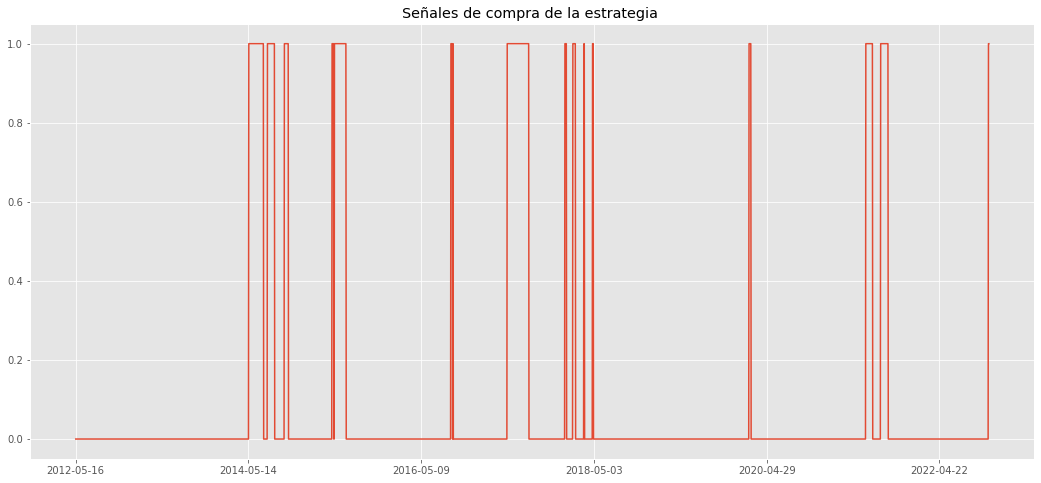

In [17]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [18]:
tiempo_final = time() 
 
tiempo_ejecucion = (tiempo_final - tiempo_inicial)/60
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"minutos") #En segundos

El tiempo de ejecucion fue: 56.48701318105062 minutos


In [19]:
data.loc['2011-01-04':'2019-11-04']

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2012-05-16,2012-05-16,0,36.189999,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-17,2012-05-17,0,35.900002,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-18,2012-05-18,0,35.84,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-21,2012-05-21,0,35.950001,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-22,2012-05-22,0,36.220001,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2019-10-29,2019-10-29,0,222.570007,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-30,2019-10-30,0,225.089996,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31,2019-10-31,0,225.660004,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-01,2019-11-01,0,230.229996,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Guardamos el resultado del analisis en un pickle
#dff.to_pickle("./primerBack_IBE.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [21]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [22]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2022-11-09,2022-11-09,0,238.789993,NaN,NaN,NaN,-0.023474,-0.0,100.231063
2022-11-10,2022-11-10,0,244.169998,NaN,NaN,NaN,0.022530,0.0,100.231063
2022-11-11,2022-11-11,0,227.580002,NaN,-99,NaN,-0.067944,-0.0,100.231063
2022-11-14,2022-11-14,1,221.119995,NaN,NaN,21.453847,-0.028386,-0.0,100.231063
2022-11-15,2022-11-15,1,223.210007,NaN,NaN,NaN,0.009452,0.009452,101.17844


In [23]:
data[60:]

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2012-08-10,2012-08-10,0,40.470001,NaN,NaN,NaN,-0.017718,-0.0,100.0
2012-08-13,2012-08-13,0,40.34,NaN,NaN,NaN,-0.003212,-0.0,100.0
2012-08-14,2012-08-14,0,40.259998,NaN,NaN,NaN,-0.001983,-0.0,100.0
2012-08-15,2012-08-15,0,40.040001,NaN,NaN,NaN,-0.005464,-0.0,100.0
2012-08-16,2012-08-16,0,40.389999,NaN,NaN,NaN,0.008741,0.0,100.0
...,...,...,...,...,...,...,...,...,...
2022-11-09,2022-11-09,0,238.789993,NaN,NaN,NaN,-0.023474,-0.0,100.231063
2022-11-10,2022-11-10,0,244.169998,NaN,NaN,NaN,0.022530,0.0,100.231063
2022-11-11,2022-11-11,0,227.580002,NaN,-99,NaN,-0.067944,-0.0,100.231063
2022-11-14,2022-11-14,1,221.119995,NaN,NaN,21.453847,-0.028386,-0.0,100.231063


>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [24]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

In [25]:
print(instrumento)

HII


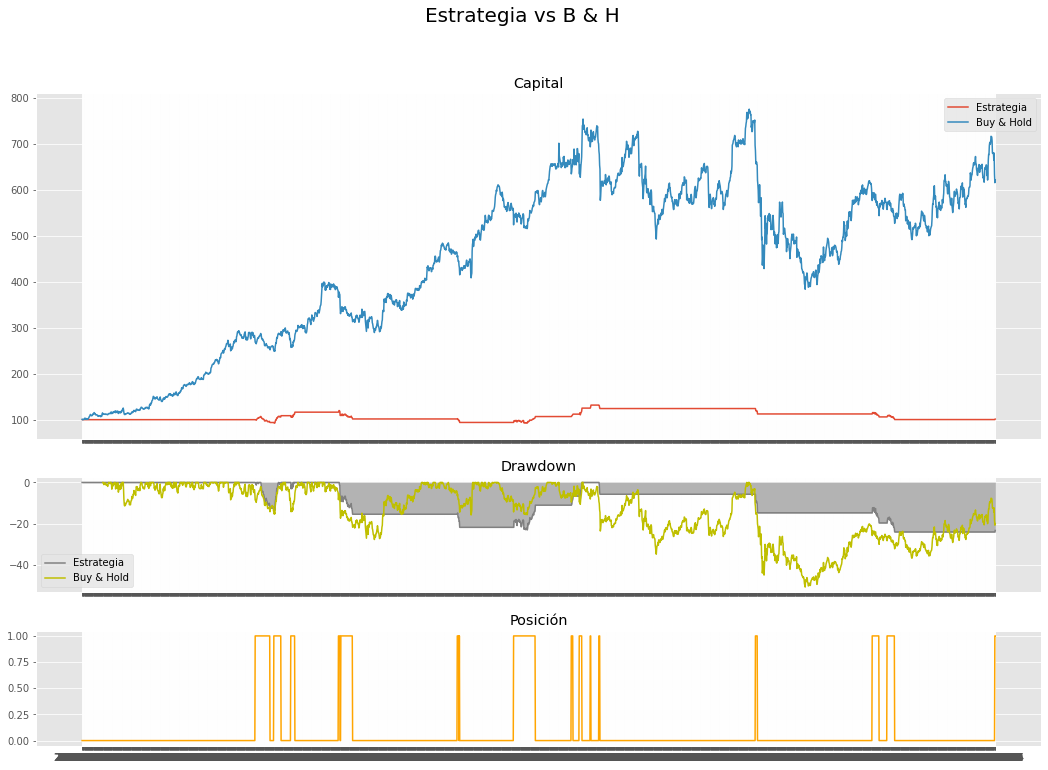

In [26]:
grafico(data)

---

In [27]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [28]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

Beneficio Bruto : 1.18 €  con una inverison de 100€


In [29]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 0.11%


In [30]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.001


In [31]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

---


In [32]:
# 

### Cálculo esperanza matemática
 
 (%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)
 
 Nos da idea el benefcio esperado por entrada

In [33]:
print("Numero operaciones con beneficio ->", 
      data[data['ExitReason'] ==1]['ExitReason'].count()) 
print("Numero operaciones con perdidas ->", 
      data[data['ExitReason'] ==-1]['ExitReason'].count()) 
  
data[data['ExitReason']>0]['ExitReason'] 

data[data['Senal']>0][1:10]
data[data['Senal']>0].index[1]

Numero operaciones con beneficio -> 6
Numero operaciones con perdidas -> 9


'2014-05-16'

In [34]:
# ENTRADAS
print (data[(data['Senal']>0) & (data['Beneficio']>0)].index[0])
data[(data['Senal']>0) & (data['Beneficio']>0) ][0:5] 
# SALIDA PERDIDAS
print (data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)].index[0])
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)][0:5]
# SALIDA GANANCIAS
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== 1)][0:5]

2014-05-15
2014-07-17


,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2014-09-02,2014-09-02,0,104.739998,NaN,1,NaN,0.025757,0.025757,108.667194
2014-10-28,2014-10-28,0,102.019997,NaN,1,NaN,0.031443,0.031443,116.329763
2017-08-03,2017-08-03,0,213.929993,NaN,1,NaN,0.027472,0.027472,106.776312
2018-01-09,2018-01-09,0,239.199997,NaN,1,NaN,0.013388,0.013388,112.016552
2018-02-15,2018-02-15,0,255.389999,NaN,1,NaN,0.057954,0.057954,125.138476


In [35]:
serieIndicesENTRADA=data[(data['Senal']>0) & (data['Beneficio']>0)].index

print(serieIndicesENTRADA.size)

serieIndicesENTRADA

serieIndicesEXIT=data[(data['ExitReason']==1) | (data['ExitReason']==-1)].index

print(serieIndicesEXIT.size)

#data['ExitReason'][serieIndicesEXIT[2]]

16
15


In [36]:
serieIndicesENTRADA

Index(['2014-05-15', '2014-08-01', '2014-10-10', '2015-04-30', '2015-05-11',
       '2016-09-09', '2016-09-19', '2017-05-04', '2018-01-02', '2018-02-05',
       '2018-03-22', '2018-04-27', '2020-02-14', '2021-06-18', '2021-08-19',
       '2022-11-14'],
      dtype='object')

In [37]:
#Cálculo Esperanza Matemática
countGanando=0
countPerdiendo=0

bolsaGanando=0
bolsaPerdiendo=0

for i in range(serieIndicesEXIT.size):
    if(data['ExitReason'][serieIndicesEXIT[i]] == -1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print ("-1",ref1, ref2)
        countPerdiendo= 1+countPerdiendo
        bolsaPerdiendo= bolsaPerdiendo + (ref1-ref2)

    
    if(data['ExitReason'][serieIndicesEXIT[i]] == 1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print ("+1",ref1, ref2)
        countGanando= 1+countGanando
        bolsaGanando= bolsaGanando + (ref1-ref2)
    
#(%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)

count=countGanando+countPerdiendo


print ("bolsa ganando   --> ", bolsaGanando, "   Número operaciones ganando   ", countGanando)   
print ("bolsa perdiendo -->", bolsaPerdiendo, "   Número operaciones perdiendo", countPerdiendo) 
print (" Media perdiendo --> ", (bolsaPerdiendo/countPerdiendo),"\n", "Media ganando --> ", (bolsaGanando/countGanando)) 


esperanza = (countGanando/count *(bolsaGanando/countGanando))+(countPerdiendo/count *(bolsaPerdiendo/countPerdiendo))
print("")
print(instrumento)
print("ESPERANZA MATEMATICA ES: ", esperanza, "///// Precio €", data['Price'][-1])



-1 90.47000122070312 96.44999694824219
+1 104.73999786376953 90.41000366210938
+1 102.0199966430664 95.30000305175781
-1 123.52999877929688 131.58999633789062
-1 112.44999694824219 120.94999694824219
-1 156.36000061035156 162.9199981689453
-1 149.11000061035156 154.6699981689453
+1 213.92999267578125 188.2100067138672
+1 239.1999969482422 228.00999450683594
+1 255.38999938964844 228.61000061035156
+1 262.239990234375 249.14999389648438
-1 231.75999450683594 245.77000427246094
-1 222.8300018310547 246.2100067138672
-1 195.30999755859375 207.17999267578125
-1 189.32000732421875 200.16000366210938
bolsa ganando   -->  97.82997131347656    Número operaciones ganando    6
bolsa perdiendo --> -94.75999450683594    Número operaciones perdiendo 9
 Media perdiendo -->  -10.528888278537327 
 Media ganando -->  16.30499521891276

HII
ESPERANZA MATEMATICA ES:  0.20466512044270946 ///// Precio € 223.2100067138672


---